[If you would like a detailed explanation of this project, please refer to the Medium article below.](https://medium.com/@ai.omar.rehan/brain-tumor-classification-using-inceptionv3-and-grad-cam-a-deep-learning-pipeline-859dbe84be1d?postPublishedType=repub)

# **Import Dependencies**

In [ ]:
import warnings
warnings.filterwarnings('ignore')

from tensorflow.keras import mixed_precision
mixed_precision.set_global_policy("mixed_float16")

import zipfile
import hashlib
import matplotlib.pyplot as plt
import pandas as pd
import os
import uuid
import re
import random
import shutil
import cv2
import numpy as np
import tensorflow as tf
import tensorflow.keras.backend as K
import seaborn as sns
from google.colab import drive
from google.colab import files
from pathlib import Path
from PIL import Image, ImageStat, UnidentifiedImageError, ImageEnhance
from matplotlib import patches
from tqdm import tqdm
from skimage.transform import resize
from collections import defaultdict, Counter
from sklearn.preprocessing import LabelEncoder, label_binarize
from sklearn.model_selection import train_test_split
from sklearn.utils import resample
from tensorflow import keras
from tensorflow.keras.applications.inception_v3 import InceptionV3, preprocess_input
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import layers, models, optimizers, callbacks, regularizers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, BatchNormalization, MaxPooling2D,Dropout, Flatten, Dense, GlobalAveragePooling2D
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam, AdamW
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint
from tensorflow.keras import Input, Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img, array_to_img
from tensorflow.keras.preprocessing import image
from sklearn.metrics import ConfusionMatrixDisplay, classification_report, confusion_matrix, roc_auc_score, roc_curve, precision_score, recall_score, f1_score, precision_recall_fscore_support, auc

print(tf.__version__)

2.19.0


In [ ]:
drive.mount('/content/drive')
zip_path = '/content/drive/MyDrive/Brain Tumor MRI.zip'
extract_to = '/content/my_data'
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_to)

Mounted at /content/drive


# **Convert Dataset to a Data Frame**

In [ ]:
image_extensions = {'.jpg', '.jpeg', '.png'}
paths = [(path.parts[-2], path.name, str(path)) for path in Path(extract_to).rglob('*.*') if path.suffix.lower() in image_extensions]

df = pd.DataFrame(paths, columns = ['class', 'image', 'full_path'])
df = df.sort_values('class', ascending = True)
df.reset_index(drop = True, inplace = True)
df

class             image  \
0        glioma    Tr-gl_0952.jpg   
1        glioma    Tr-gl_0414.jpg   
2        glioma    Tr-gl_0294.jpg   
3        glioma    Te-gl_0019.jpg   
4        glioma  Tr-glTr_0007.jpg   
...         ...               ...   
7018  pituitary    Tr-pi_1179.jpg   
7019  pituitary    Tr-pi_0044.jpg   
7020  pituitary    Tr-pi_1317.jpg   
7021  pituitary    Tr-pi_0455.jpg   
7022  pituitary    Tr-pi_1390.jpg   

                                              full_path  
0     /content/my_data/Brain Tumor MRI/glioma/Tr-gl_...  
1     /content/my_data/Brain Tumor MRI/glioma/Tr-gl_...  
2     /content/my_data/Brain Tumor MRI/glioma/Tr-gl_...  
3     /content/my_data/Brain Tumor MRI/glioma/Te-gl_...  
4     /content/my_data/Brain Tumor MRI/glioma/Tr-glT...  
...                                                 ...  
7018  /content/my_data/Brain Tumor MRI/pituitary/Tr-...  
7019  /content/my_data/Brain Tumor MRI/pituitary/Tr-...  
7020  /content/my_data/Brain Tumor MRI/pituitary/Tr-...  
7021  /content/my_data/Brain Tumor MRI/pituitary/Tr-...  
7022  /content/my_data/Brain Tumor MRI/pituitary/Tr-...  

[7023 rows x 3 columns]

# **EDA Process**

In [ ]:
# Count per class
class_count = df['class'].value_counts()
for cls, count in class_count.items():
    print(f'Class: {cls}, Count: {count} images')

print(f"\nTotal dataset size is: {len(df)} images")
print(f"Number of classes: {df['class'].nunique()} classes")

extensions = [os.path.splitext(fname)[1].lower() for fname in df['image']]
ext_count = Counter(extensions)

print("\nImage format distribution:")
for ext, count in ext_count.items():
    print(f"Extension: {ext}, Count: {count} images")

Class: notumor, Count: 2000 images
Class: pituitary, Count: 1757 images
Class: meningioma, Count: 1645 images
Class: glioma, Count: 1621 images

Total dataset size is: 7023 images
Number of classes: 4 classes

Image format distribution:
Extension: .jpg, Count: 7023 images


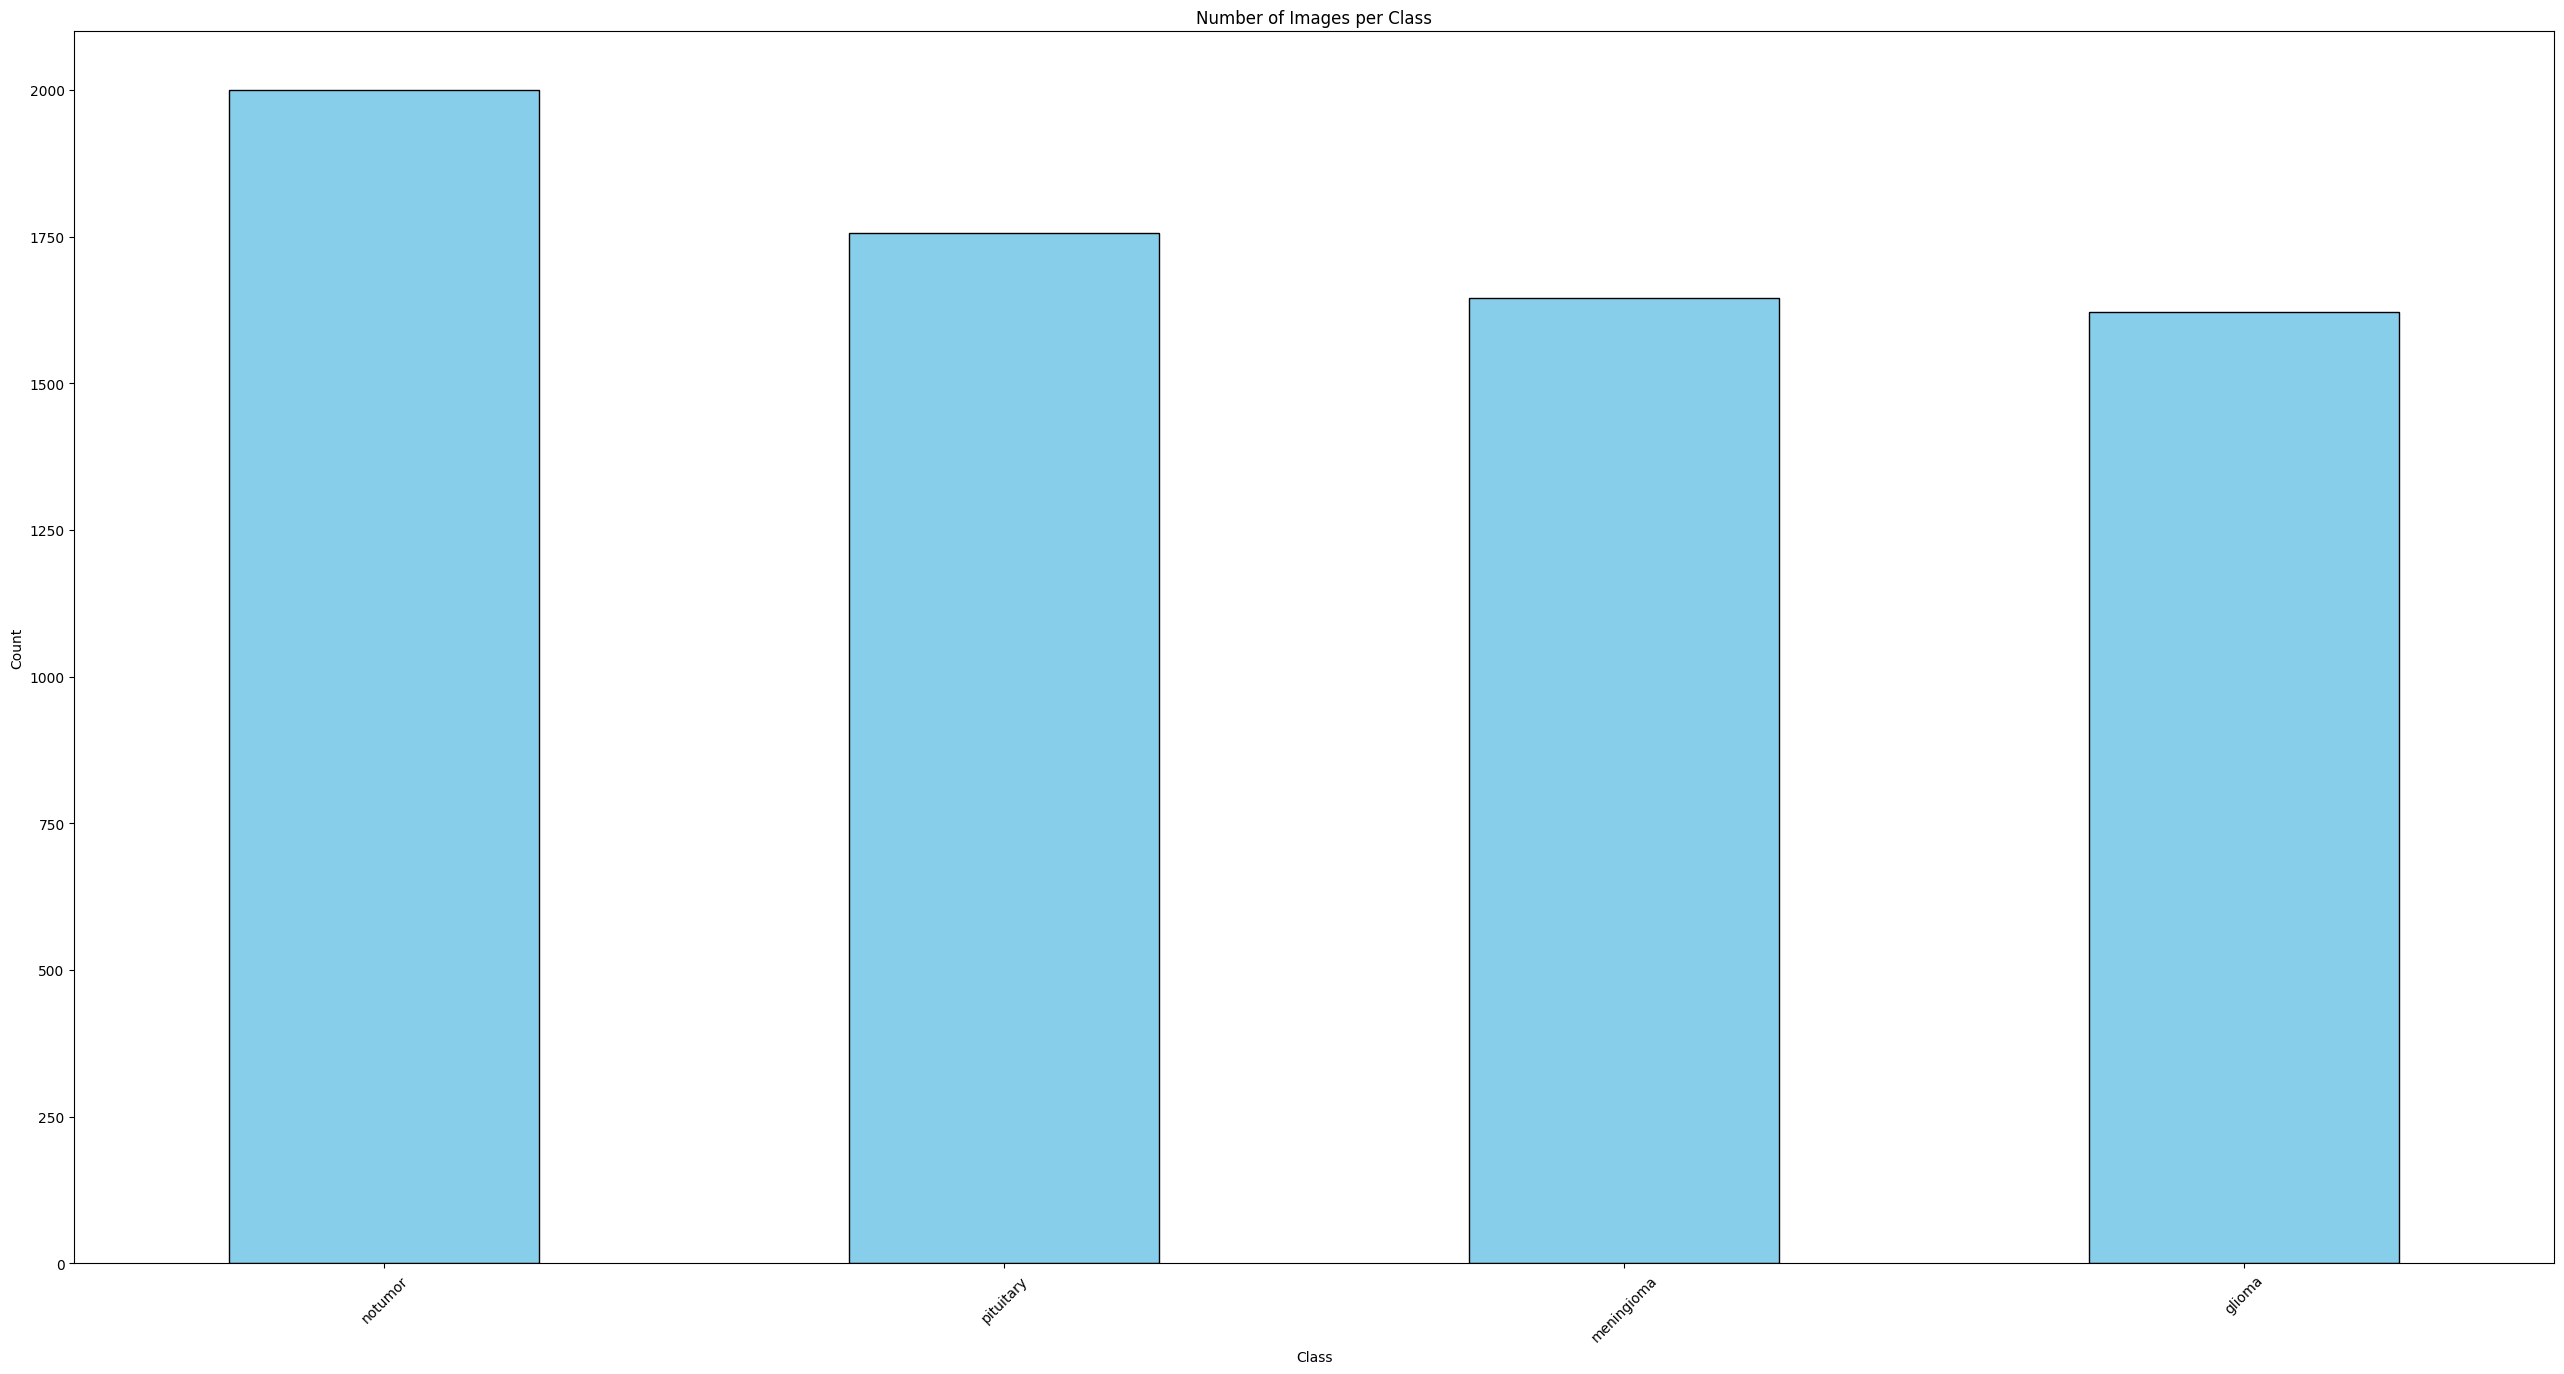

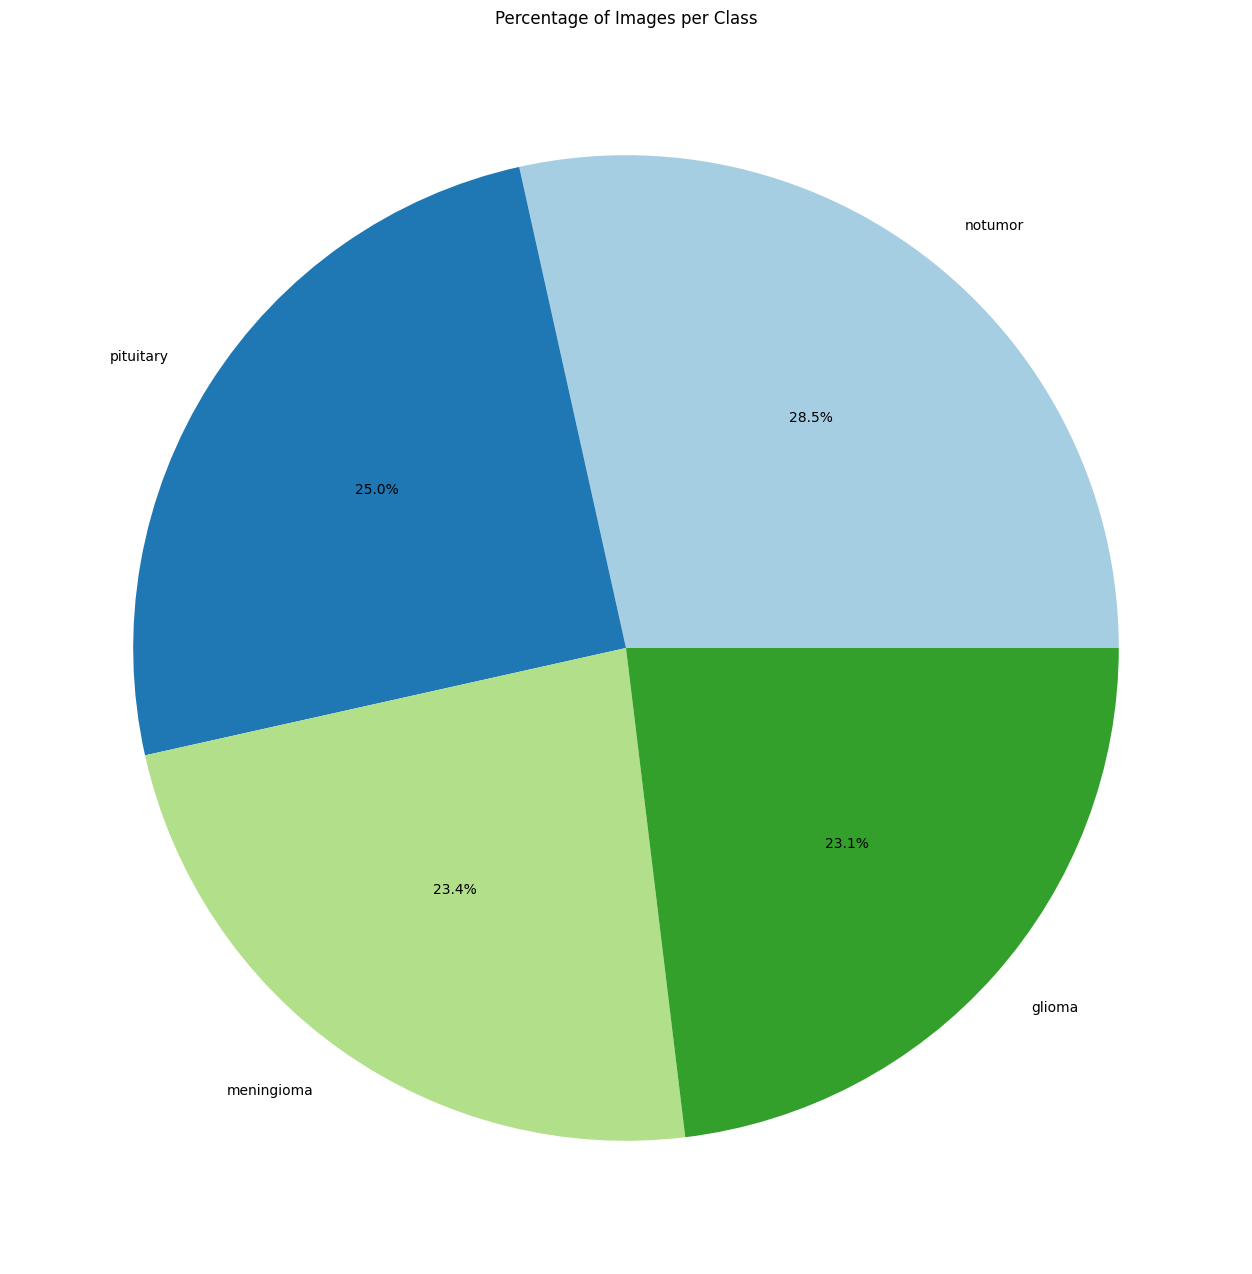

In [ ]:
plt.figure(figsize = (32, 16))
class_count.plot(kind = 'bar', color = 'skyblue', edgecolor = 'black')
plt.title('Number of Images per Class')
plt.xlabel('Class')
plt.ylabel('Count')
plt.xticks(rotation = 45)
plt.show()

plt.figure(figsize = (32, 16))
class_count.plot(kind = 'pie', autopct = '%1.1f%%', colors = plt.cm.Paired.colors)
plt.title('Percentage of Images per Class')
plt.ylabel('')
plt.show()

            Count  Percentage %
class                          
notumor      2000         28.48
pituitary    1757         25.02
meningioma   1645         23.42
glioma       1621         23.08


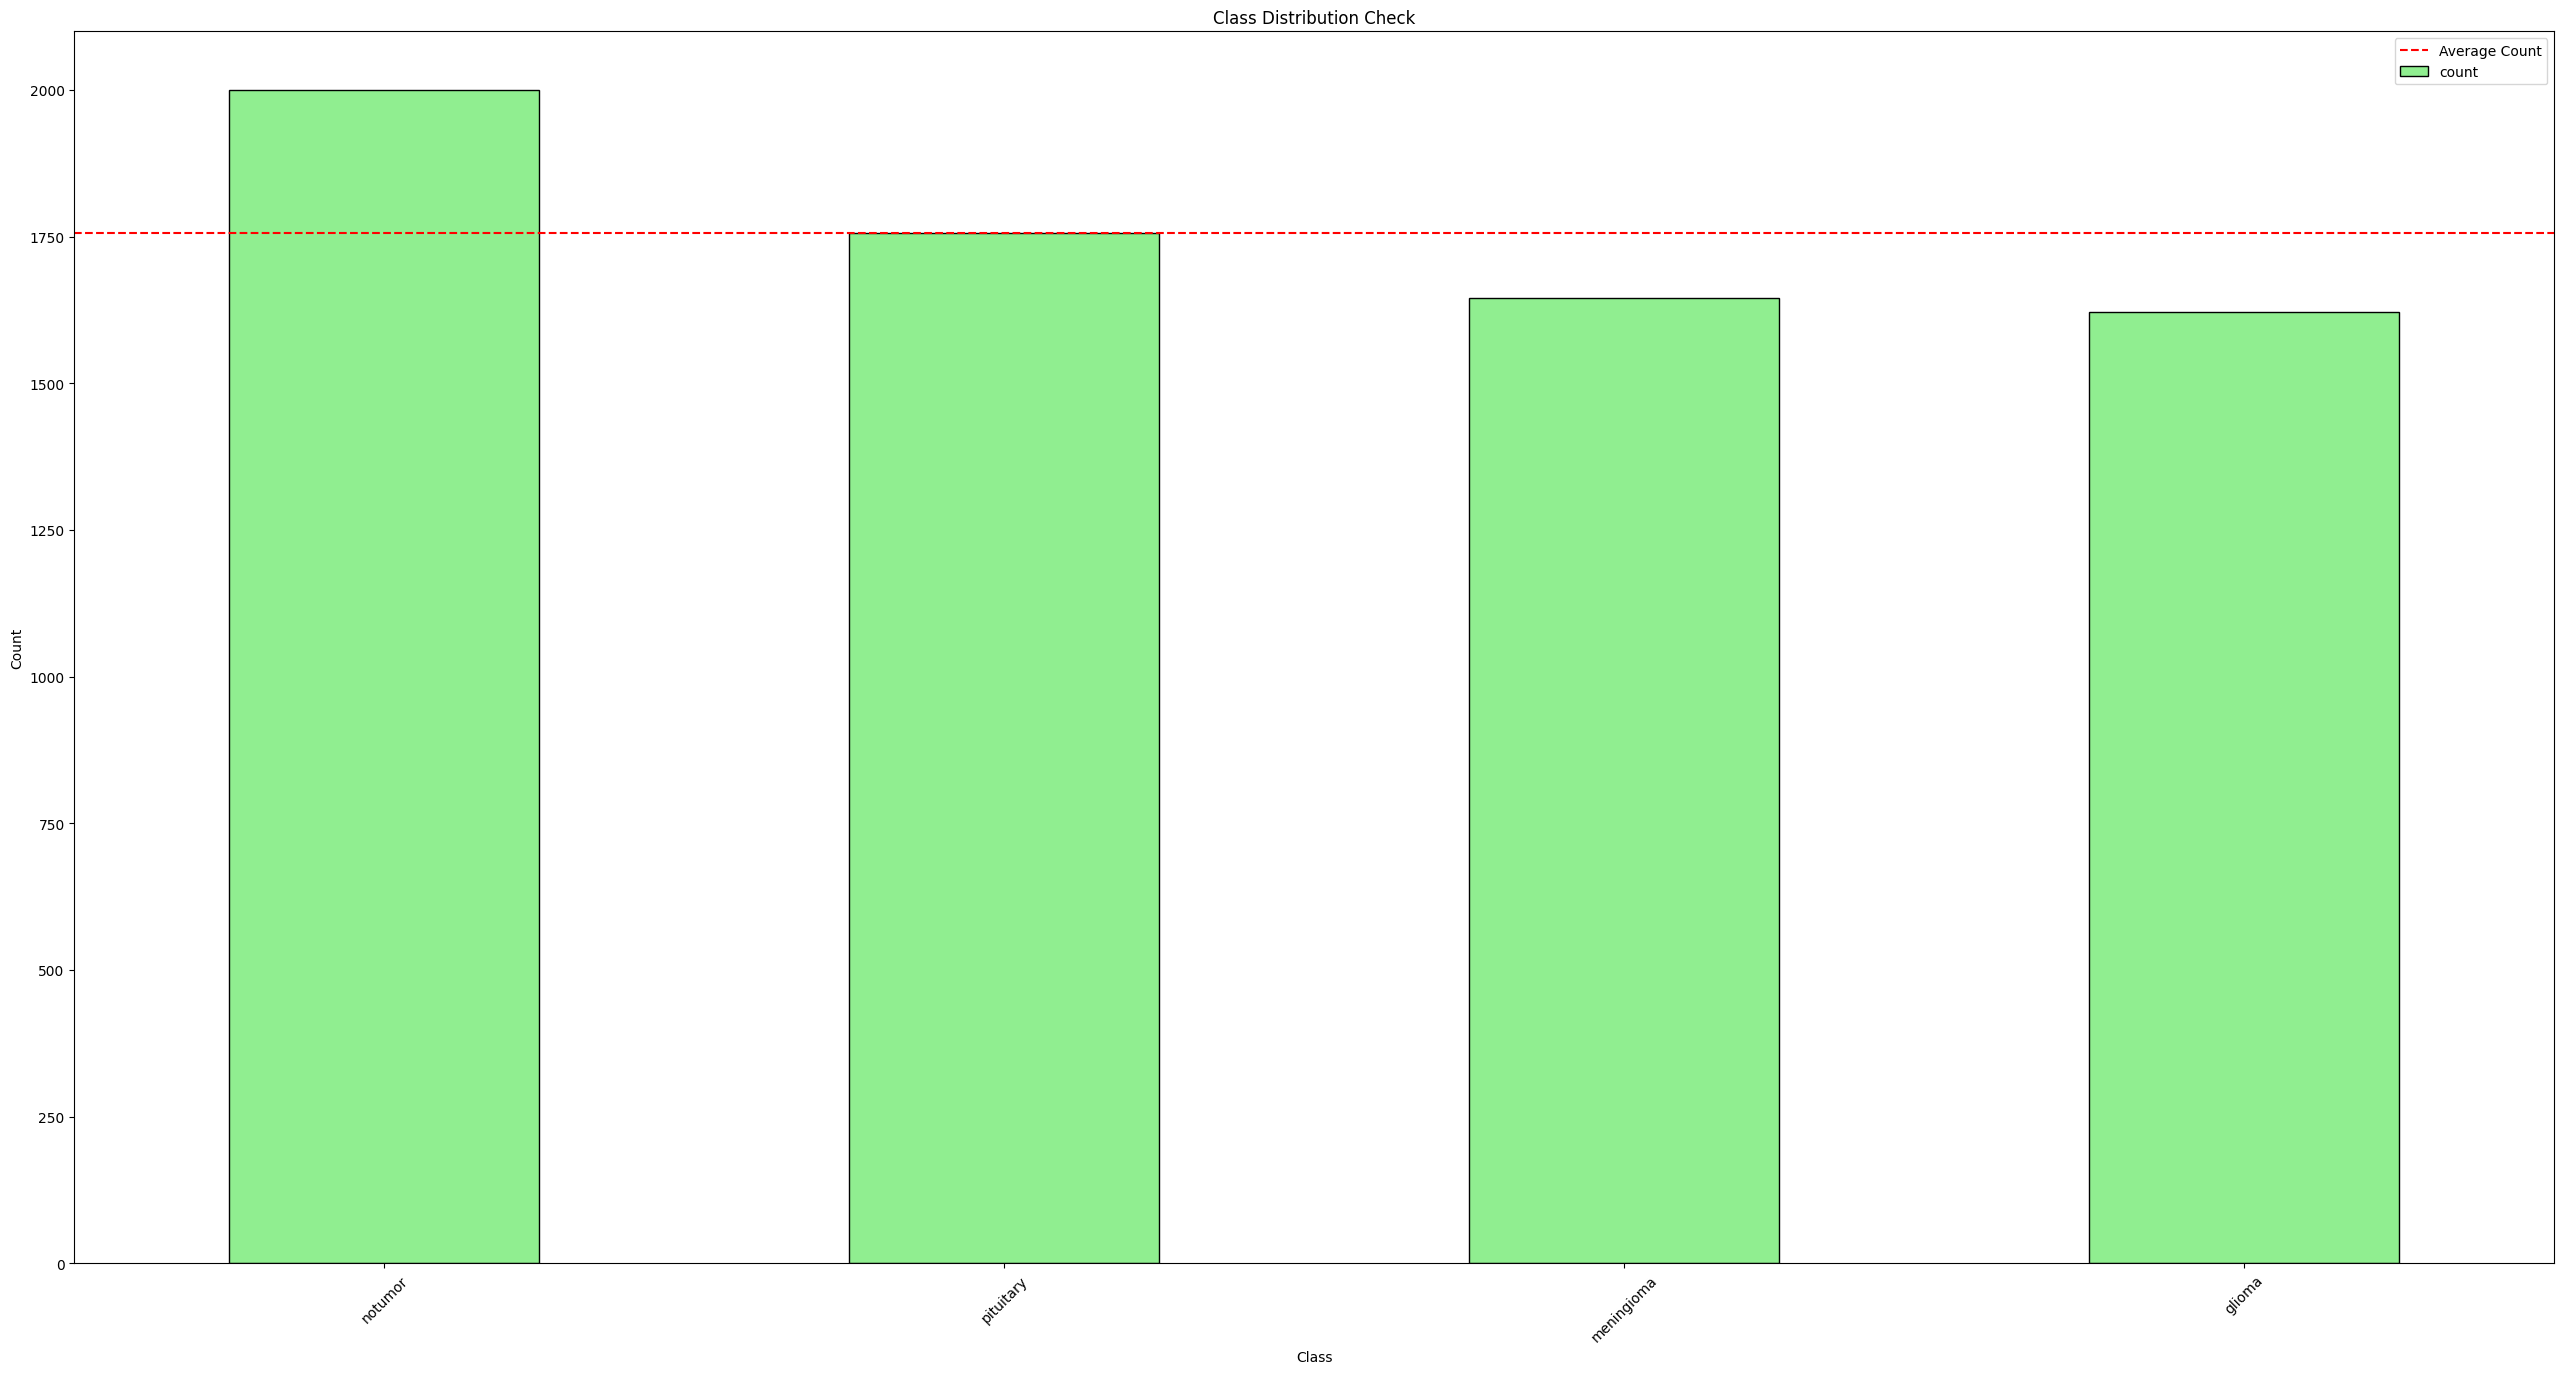

In [ ]:
percentages = (class_count / len(df)) * 100
imbalance_df = pd.DataFrame({'Count': class_count, 'Percentage %': percentages.round(2)})
print(imbalance_df)

plt.figure(figsize = (32, 16))
class_count.plot(kind = 'bar', color = 'lightgreen', edgecolor = 'black')
plt.title('Class Distribution Check')
plt.xlabel('Class')
plt.ylabel('Count')
plt.xticks(rotation = 45)
plt.axhline(y = class_count.mean(), color = 'red', linestyle = '--', label = 'Average Count')
plt.legend()

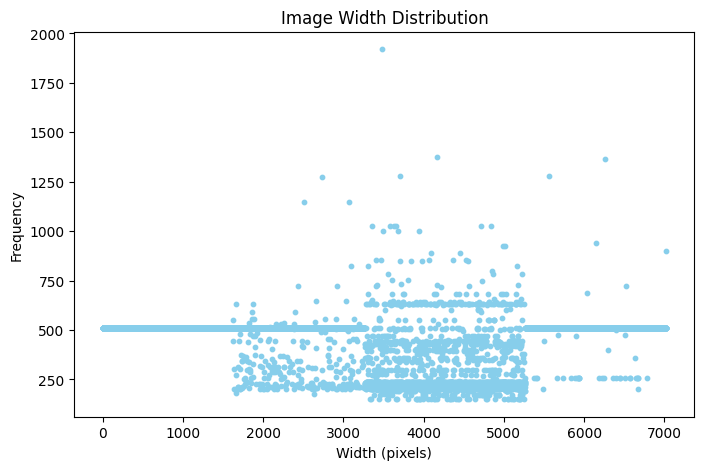

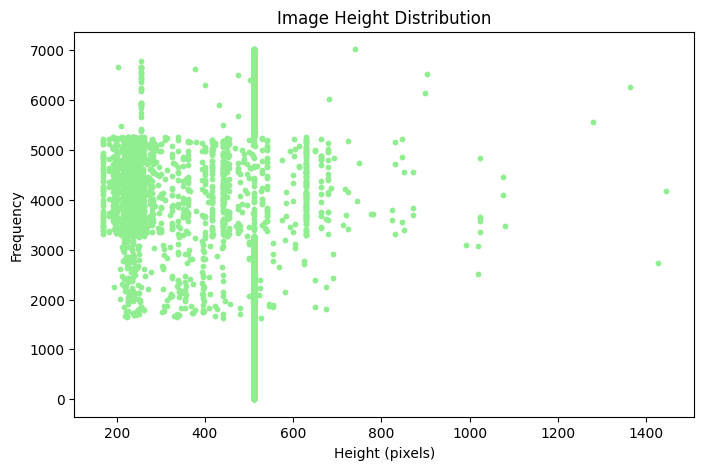

     Width  Height  Count
0      512     512   4742
1      225     225    332
2      630     630     90
3      236     236     81
4      201     251     58
..     ...     ...    ...
382    630     614      1
383    648     674      1
384   1365    1365      1
385   1375    1446      1
386   1920    1080      1

[387 rows x 3 columns]
Image Mode Distribution:
Mode
RGB     3926
L       3093
RGBA       3
P          1
Name: count, dtype: int64

Number of Channels Distribution:
Channels
3    3926
1    3094
4       3
Name: count, dtype: int64


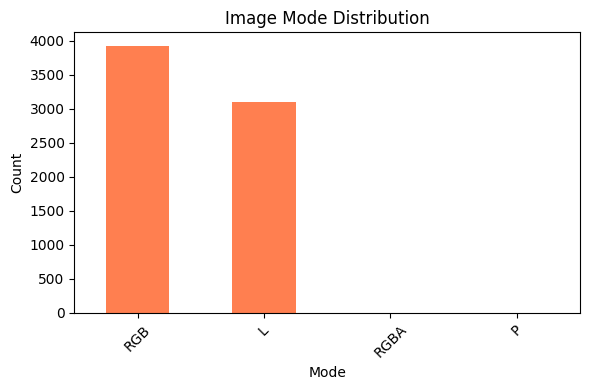

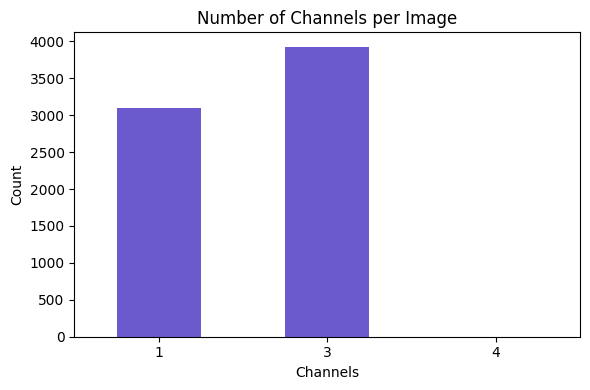

In [ ]:
image_sizes = []

for file_path in df['full_path']:
    with Image.open(file_path) as img:
        image_sizes.append(img.size)

sizes_df = pd.DataFrame(image_sizes, columns=['Width', 'Height'])

#Width
plt.figure(figsize=(8,5))
plt.scatter(x = range(len(sizes_df)), y = sizes_df['Width'], color='skyblue', s=10)
plt.title('Image Width Distribution')
plt.xlabel('Width (pixels)')
plt.ylabel('Frequency')
plt.show()

#Height
plt.figure(figsize=(8,5))
plt.scatter(x = sizes_df['Height'], y = range(len(sizes_df)), color='lightgreen', s=10)
plt.title('Image Height Distribution')
plt.xlabel('Height (pixels)')
plt.ylabel('Frequency')
plt.show()

#For best sure the size of the whole images
unique_sizes = sizes_df.value_counts().reset_index(name='Count')
print(unique_sizes)

image_data = []

for file_path in df['full_path']:
    with Image.open(file_path) as img:
        width, height = img.size
        mode = img.mode  # e.g., 'RGB', 'L', 'RGBA', etc.
        channels = len(img.getbands())  # Number of channels
        image_data.append((width, height, mode, channels))

# Create DataFrame
image_df = pd.DataFrame(image_data, columns=['Width', 'Height', 'Mode', 'Channels'])

print("Image Mode Distribution:")
print(image_df['Mode'].value_counts())

print("\nNumber of Channels Distribution:")
print(image_df['Channels'].value_counts())

plt.figure(figsize=(6,4))
image_df['Mode'].value_counts().plot(kind='bar', color='coral')
plt.title("Image Mode Distribution")
plt.xlabel("Mode")
plt.ylabel("Count")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

plt.figure(figsize=(6,4))
image_df['Channels'].value_counts().sort_index().plot(kind='bar', color='slateblue')
plt.title("Number of Channels per Image")
plt.xlabel("Channels")
plt.ylabel("Count")
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

In [ ]:
# Target directory for balanced dataset
balanced_dir = "/content/my_data_balanced"
os.makedirs(balanced_dir, exist_ok=True)

# Define augmentation generator
datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    fill_mode='nearest'
)

target_count = 2000  # max per class

for cls in tqdm(df['class'].unique(), desc="Balancing classes"):
    class_df = df[df['class'] == cls]
    class_paths = class_df['full_path'].tolist()
    class_dir = os.path.join(balanced_dir, cls)
    os.makedirs(class_dir, exist_ok=True)

    # Copy originals first
    for path in class_paths:
        shutil.copy(path, class_dir)

    current_count = len(class_paths)
    if current_count >= target_count:
        continue

    num_to_generate = target_count - current_count
    gen_count = 0

    # Cycle through original images until we reach target_count
    while gen_count < num_to_generate:
        for img_path in class_paths:
            if gen_count >= num_to_generate:
                break

            img = load_img(img_path, target_size=(224, 224))
            x = img_to_array(img)
            x = np.expand_dims(x, axis=0)

            # Just one augmented version per image at a time
            batch = next(datagen.flow(x, batch_size=1))
            base_name = os.path.splitext(os.path.basename(img_path))[0]
            new_filename = f"aug_{base_name}_{uuid.uuid4().hex}.jpg"
            save_path = os.path.join(class_dir, new_filename)
            array_to_img(batch[0]).save(save_path)

            gen_count += 1

print("\nDataset balanced and saved at:", balanced_dir)

Balancing classes: 100%|██████████| 4/4 [00:13<00:00,  3.33s/it]


Dataset balanced and saved at: /content/my_data_balanced


In [ ]:
image_extensions = {'.jpg', '.jpeg', '.png'}
paths = [(path.parts[-2], path.name, str(path)) for path in Path(balanced_dir).rglob('*.*') if path.suffix.lower() in image_extensions]

df = pd.DataFrame(paths, columns = ['class', 'image', 'full_path'])
df = df.sort_values('class', ascending = True)
df.reset_index(drop = True, inplace = True)
df

class                                              image  \
0        glioma                                     Tr-gl_1245.jpg   
1        glioma                                     Tr-gl_0457.jpg   
2        glioma                                     Te-gl_0071.jpg   
3        glioma  aug_Tr-gl_0508_3b188eee190e4d14b154a2efae97f65...   
4        glioma  aug_Tr-gl_0662_45371cdee6bf449ea308ffa022ae321...   
...         ...                                                ...   
7995  pituitary                                     Tr-pi_1286.jpg   
7996  pituitary                                     Tr-pi_0676.jpg   
7997  pituitary  aug_Tr-pi_1348_7e5cbdd48d774979a04fd72904ed6a5...   
7998  pituitary  aug_Tr-pi_0218_32ed5ae775444c3ba9a5abc5d5a6e46...   
7999  pituitary  aug_Tr-pi_1385_85b566b1adea40ecbff7a663bcf49cd...   

                                              full_path  
0       /content/my_data_balanced/glioma/Tr-gl_1245.jpg  
1       /content/my_data_balanced/glioma/Tr-gl_0457.jpg  
2       /content/my_data_balanced/glioma/Te-gl_0071.jpg  
3     /content/my_data_balanced/glioma/aug_Tr-gl_050...  
4     /content/my_data_balanced/glioma/aug_Tr-gl_066...  
...                                                 ...  
7995  /content/my_data_balanced/pituitary/Tr-pi_1286...  
7996  /content/my_data_balanced/pituitary/Tr-pi_0676...  
7997  /content/my_data_balanced/pituitary/aug_Tr-pi_...  
7998  /content/my_data_balanced/pituitary/aug_Tr-pi_...  
7999  /content/my_data_balanced/pituitary/aug_Tr-pi_...  

[8000 rows x 3 columns]

In [ ]:
# Count per class
class_count = df['class'].value_counts()
for cls, count in class_count.items():
    print(f'Class: {cls}, Count: {count} images')

print(f"\nTotal dataset size is: {len(df)} images")
print(f"Number of classes: {df['class'].nunique()} classes")

extensions = [os.path.splitext(fname)[1].lower() for fname in df['image']]
ext_count = Counter(extensions)

print("\nImage format distribution:")
for ext, count in ext_count.items():
    print(f"Extension: {ext}, Count: {count} images")

Class: glioma, Count: 2000 images
Class: meningioma, Count: 2000 images
Class: notumor, Count: 2000 images
Class: pituitary, Count: 2000 images

Total dataset size is: 8000 images
Number of classes: 4 classes

Image format distribution:
Extension: .jpg, Count: 8000 images


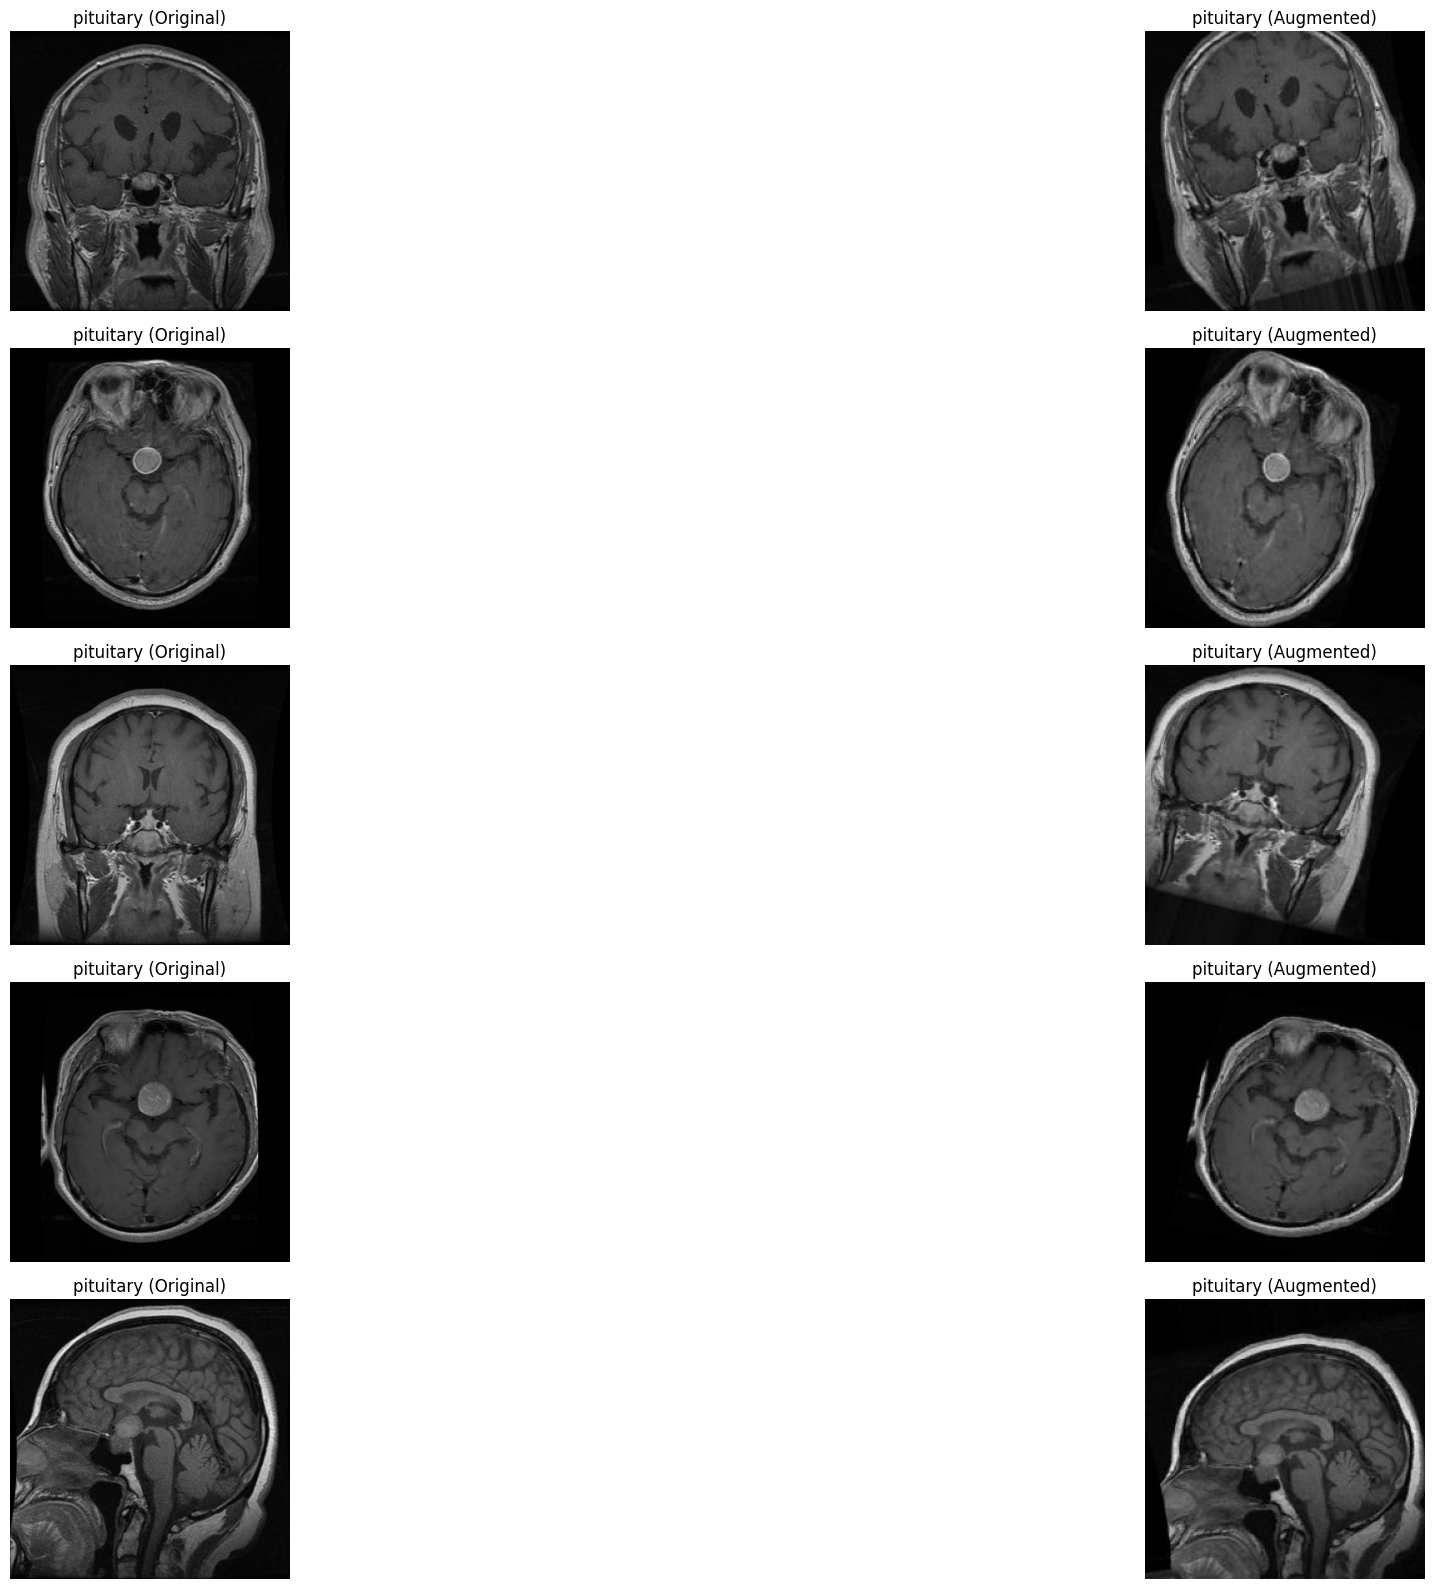

In [ ]:
# Pick a random class to visualize
random_class = random.choice(df['class'].unique())
class_df = df[df['class'] == random_class]

# Map originals to their augmentations
pairs = []
for orig_path in class_df[~class_df['image'].str.startswith("aug_")]['full_path']:
    base_name = os.path.splitext(os.path.basename(orig_path))[0]
    # Find all augmentations containing this base_name
    related_augs = class_df[class_df['image'].str.contains(f"aug_{base_name}")]['full_path'].tolist()
    if related_augs:
        pairs.append((orig_path, random.choice(related_augs)))  # pick one augmentation

# Pick up to 5 pairs
pairs = random.sample(pairs, min(5, len(pairs)))

plt.figure(figsize=(32, 16))
for i, (orig, aug) in enumerate(pairs):
    # Show original
    plt.subplot(len(pairs), 2, 2*i+1)
    plt.imshow(Image.open(orig).convert("RGB"))
    plt.title(f"{random_class} (Original)")
    plt.axis("off")

    # Show augmented
    plt.subplot(len(pairs), 2, 2*i+2)
    plt.imshow(Image.open(aug).convert("RGB"))
    plt.title(f"{random_class} (Augmented)")
    plt.axis("off")

plt.tight_layout()
plt.show()

Image: Te-me_0035.jpg | Class: meningioma | Size: 300x412 | Brightness: 73.6 | Contrast: 82.7
Image: Tr-me_0862.jpg | Class: meningioma | Size: 512x512 | Brightness: 45.1 | Contrast: 48.0
Image: Tr-gl_0698.jpg | Class: glioma | Size: 512x512 | Brightness: 22.5 | Contrast: 33.0
Image: aug_Tr-me_0533_1d39489f3d3a4de485cb745409c10685.jpg | Class: meningioma | Size: 224x224 | Brightness: 37.4 | Contrast: 42.4
Image: Tr-no_0674.jpg | Class: notumor | Size: 173x201 | Brightness: 84.1 | Contrast: 72.4
Image: Tr-me_0386.jpg | Class: meningioma | Size: 512x512 | Brightness: 38.8 | Contrast: 49.1
Image: Tr-gl_0648.jpg | Class: glioma | Size: 512x512 | Brightness: 13.7 | Contrast: 26.9
Image: Te-gl_0260.jpg | Class: glioma | Size: 512x512 | Brightness: 41.3 | Contrast: 39.7
Image: Tr-no_1338.jpg | Class: notumor | Size: 225x225 | Brightness: 84.1 | Contrast: 71.1
Image: Tr-me_0932.jpg | Class: meningioma | Size: 512x512 | Brightness: 40.2 | Contrast: 47.4


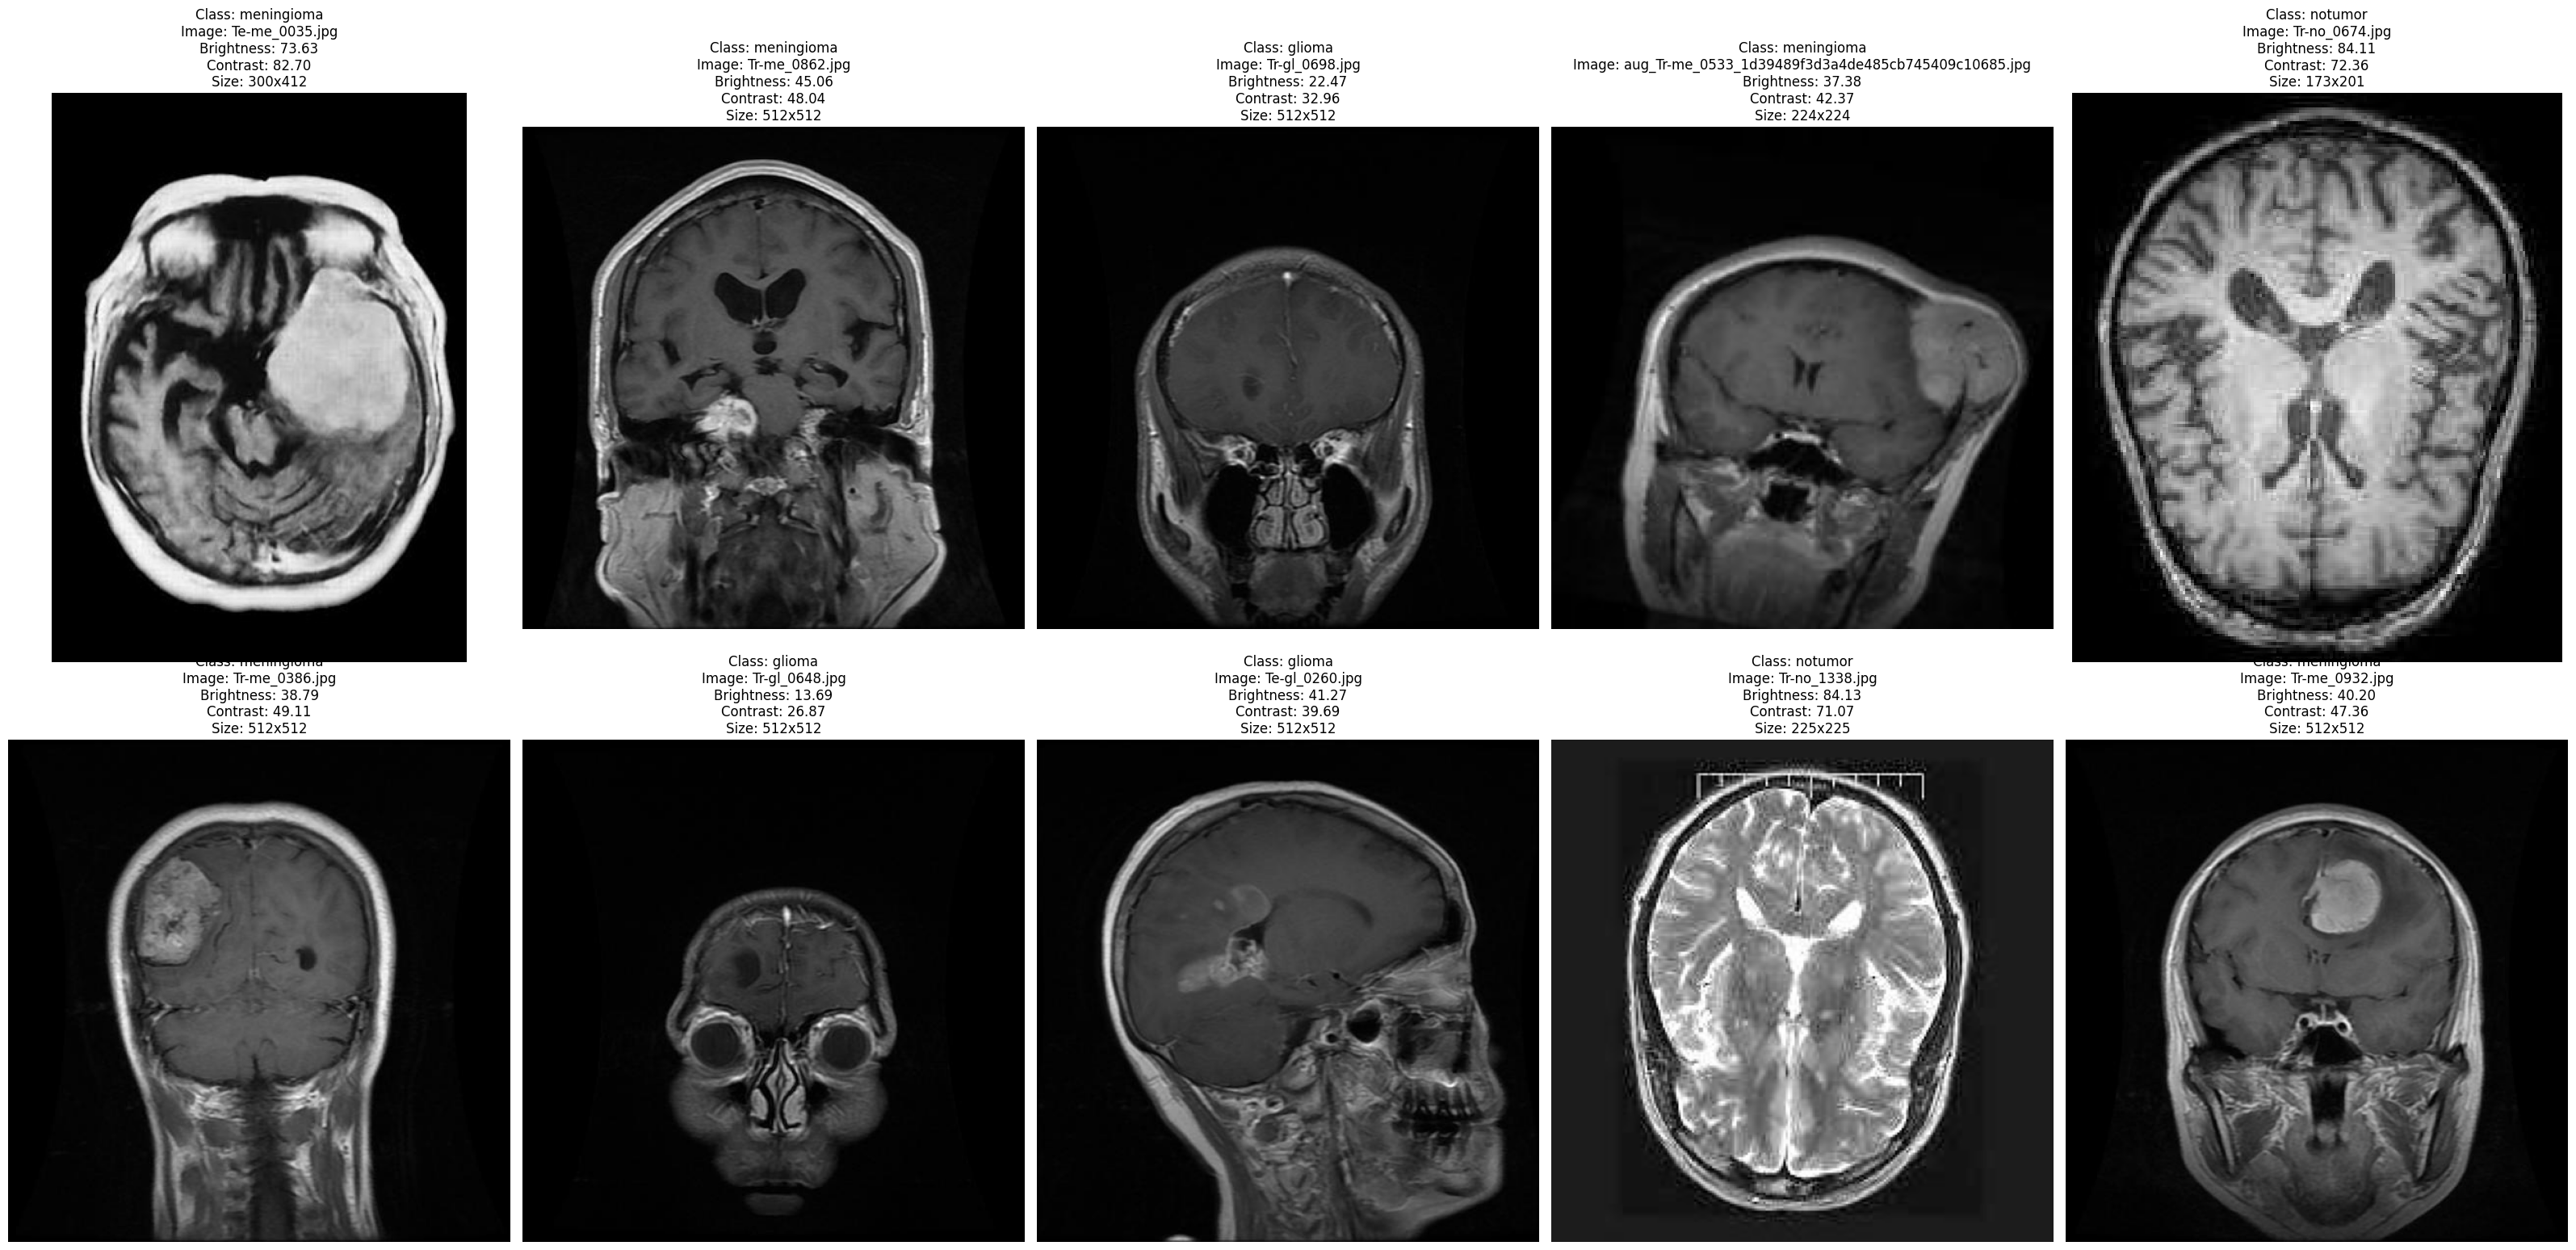

In [ ]:
sample_df = df.sample(n=10, random_state=42)

plt.figure(figsize=(32, 16))

for i, (cls, img_name, full_path) in enumerate(sample_df.values):
    with Image.open(full_path) as img:
        img_rgb = img.convert("RGB")   # always RGB for plotting

        stat = ImageStat.Stat(img_rgb)
        brightness = stat.mean[0]
        contrast = stat.stddev[0]

        width, height = img.size
        print(f"Image: {img_name} | Class: {cls} | Size: {width}x{height} | Brightness: {brightness:.1f} | Contrast: {contrast:.1f}")

        plt.subplot(2, 5, i + 1)
        plt.imshow(img_rgb)   # plot RGB version
        plt.axis('off')
        plt.title(
            f"Class: {cls}\n"
            f"Image: {img_name}\n"
            f"Brightness: {brightness:.2f}\n"
            f"Contrast: {contrast:.2f}\n"
            f"Size: {width}x{height}"
        )

plt.tight_layout()
plt.show()

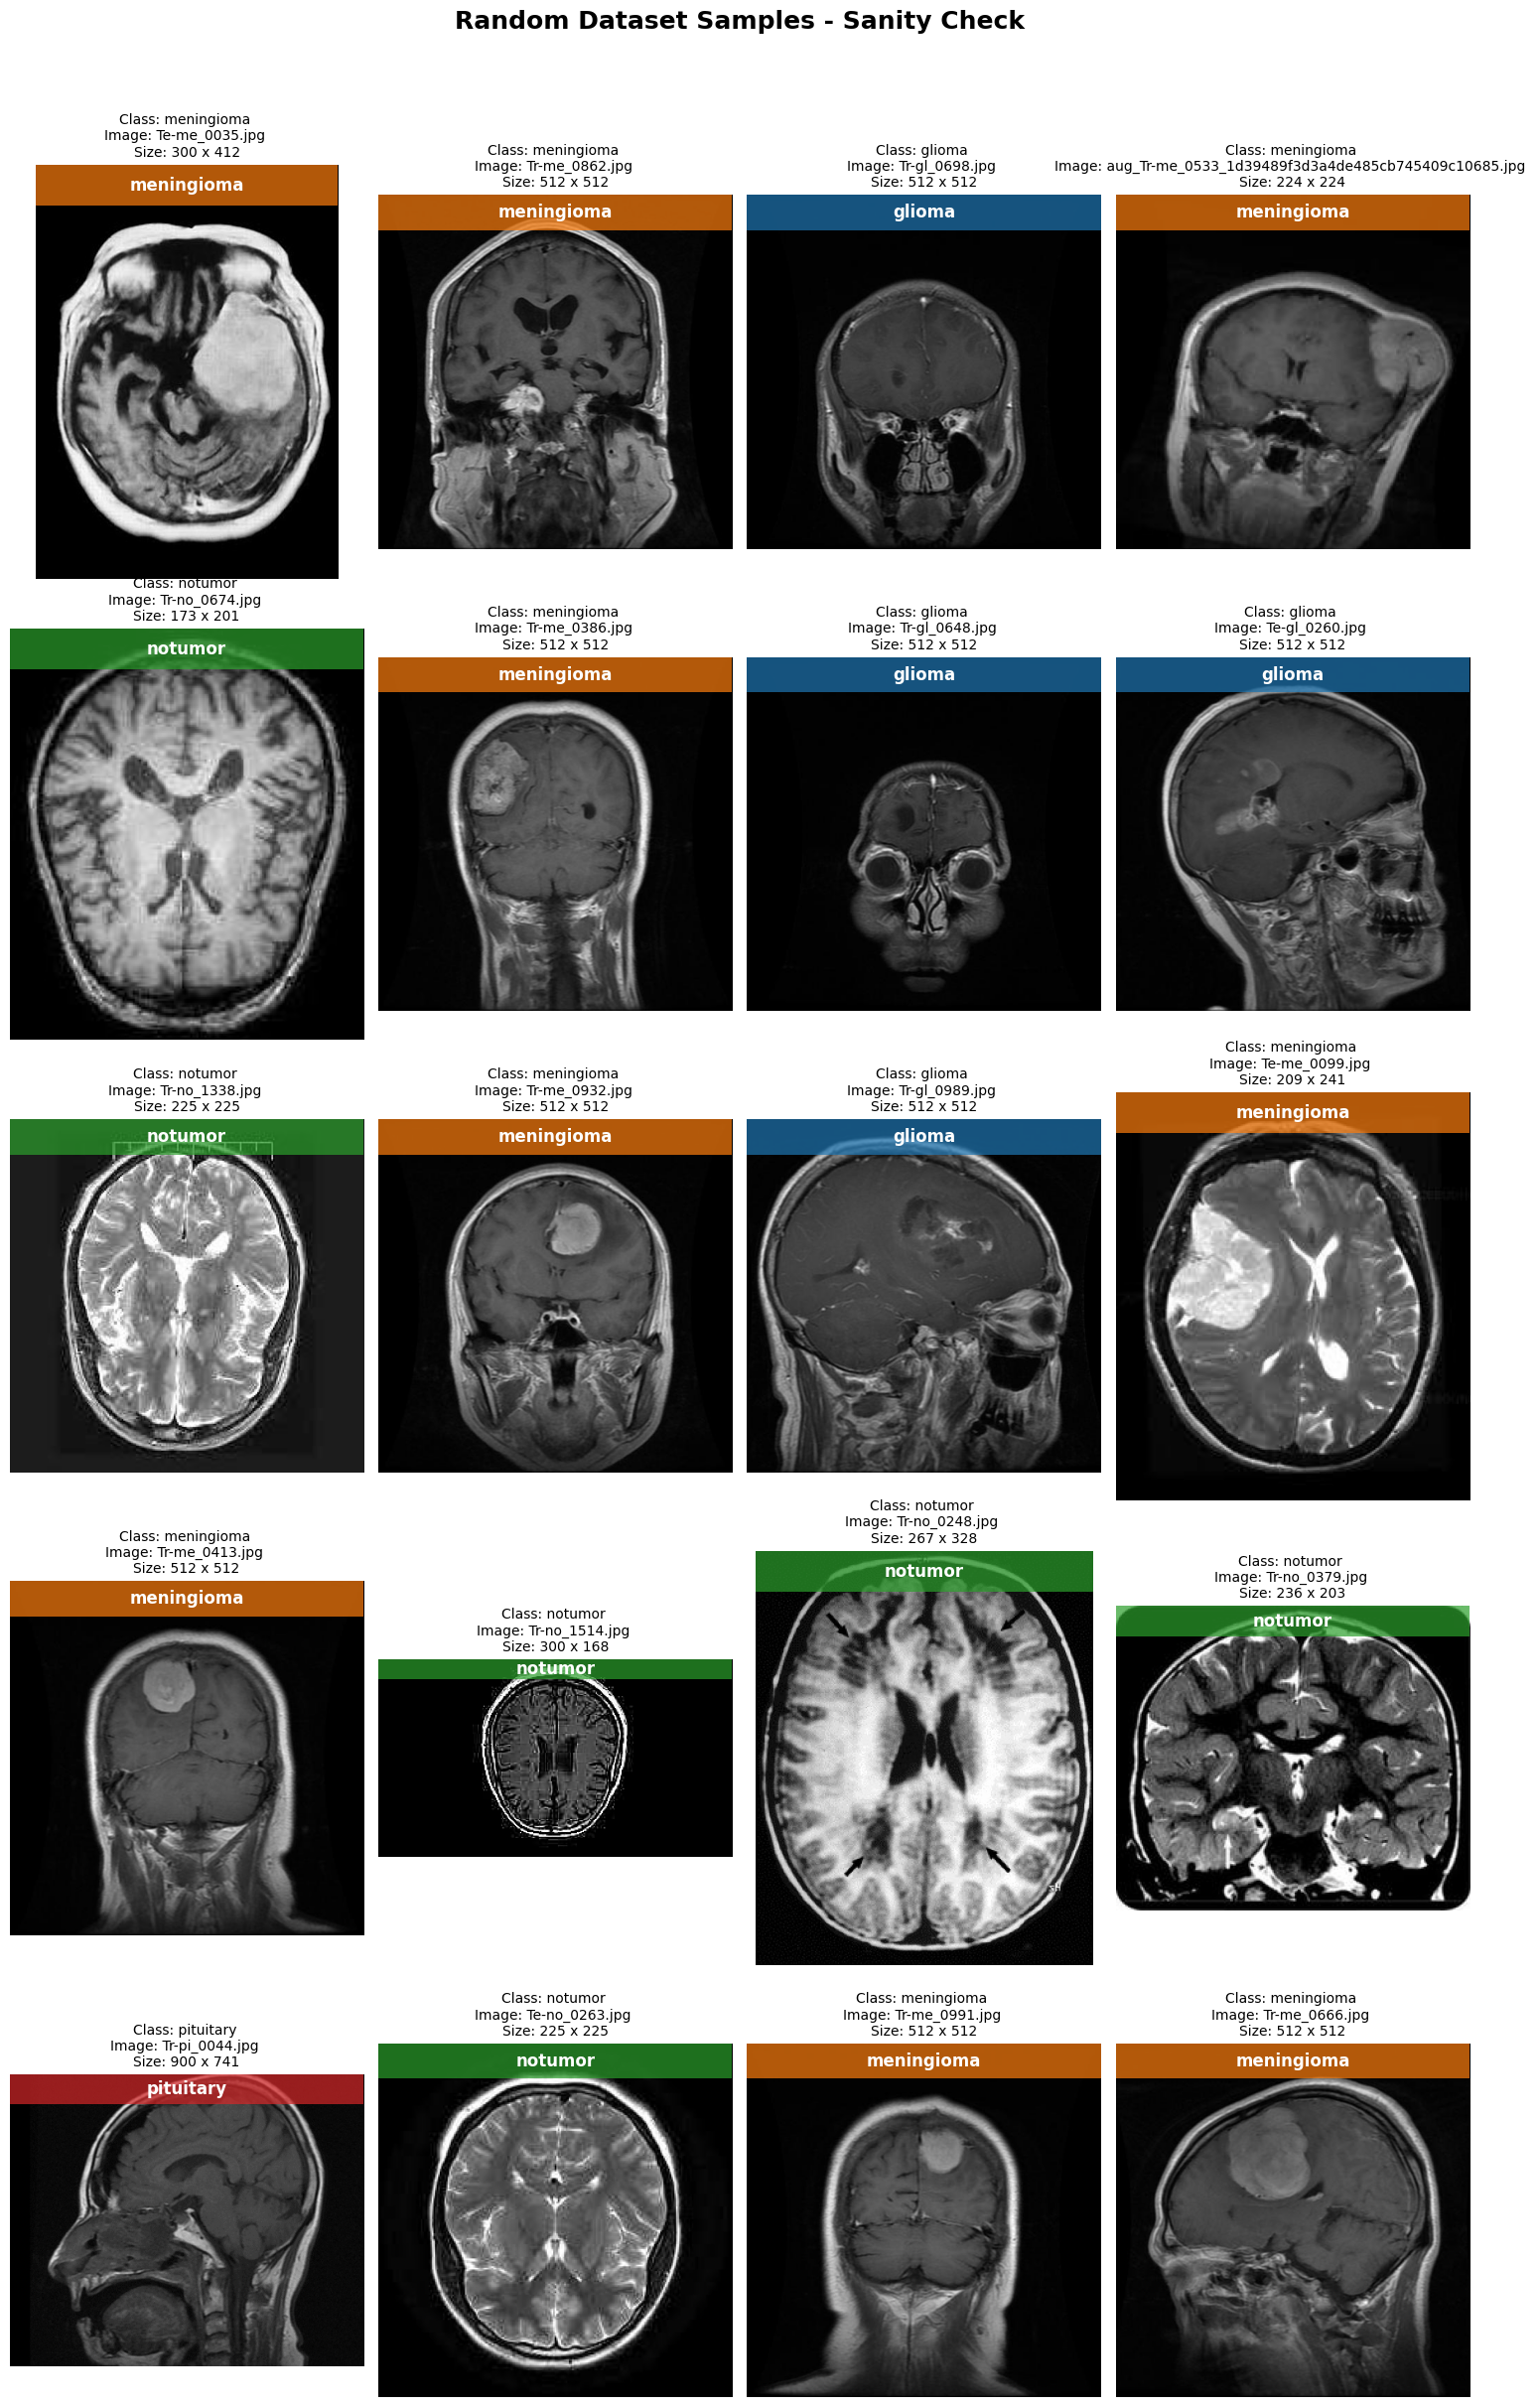

In [ ]:
# Sample 20 random images
num_samples = 20
sample_df = df.sample(num_samples, random_state=42)

# Get sorted class list and color map
classes = sorted(df['class'].unique())
colors = plt.cm.tab10.colors

# Grid setup
cols = 4
rows = num_samples // cols + int(num_samples % cols > 0)

# Figure setup
plt.figure(figsize=(15, 5 * rows))

for idx, (cls, img_name, full_path) in enumerate(sample_df.values):
    with Image.open(full_path) as img:
        img_rgb = img.convert("RGB")
        ax = plt.subplot(rows, cols, idx + 1)
        ax.imshow(img_rgb)
        ax.axis('off')

        # Title with class info
        ax.set_title(
            f"Class: {cls} \nImage: {img_name} \nSize: {img.width} x {img.height}",
            fontsize=10
        )

        label_height = 0.1  # 10% of image height
        label_width = 1.0   # full width of the image

        rect = patches.Rectangle(
        (0, 1 - label_height), label_width, label_height,
        transform=ax.transAxes,
        linewidth=0,
        edgecolor=None,
        facecolor=colors[classes.index(cls) % len(colors)],
        alpha=0.7
      )
        ax.add_patch(rect)

        # Add class name text centered horizontally
        ax.text(
        0.5, 1 - label_height / 2,
        cls,
        transform=ax.transAxes,
        fontsize=12,
        color="white",
        fontweight="bold",
        va="center",
        ha="center"
      )

# Figure title and layout
plt.suptitle("Random Dataset Samples - Sanity Check", fontsize=18, fontweight="bold")
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

In [ ]:
#Check missing files
print("Missing values per column: ")
print(df.isnull().sum())

#Check duplicate files
duplicate_names = df.duplicated().sum()
print(f"\nNumber of duplicate files: {duplicate_names}")

duplicate_names = df[df.duplicated(subset = ['image'], keep = False)]
print(f"Duplicate file names: {len(duplicate_names)}")

#Check if two images or more are the same even if they are having different file names
def get_hash(file_path):
    with open(file_path, 'rb') as f:
        return hashlib.md5(f.read()).hexdigest()

df['file_hash'] = df['full_path'].apply(get_hash)
duplicate_hashes = df[df.duplicated(subset = ['file_hash'], keep = False)]
print(f"Duplicate image files: {len(duplicate_hashes)}")

#This code below just removing the duplicate files, which means will not be feeded to the model, but will be still in the actual directory
#Important note: duplicates are removed from the dataframe only, not from the actual directory.
#Drop duplicates based on file_hash, keeping the first one

# df_unique = df.drop_duplicates(subset='file_hash', keep='first')
# print(f"After removing duplicates, unique images: {len(df_unique)}")

#Check for images extentions
df['extenstion'] = df['image'].apply(lambda x: Path(x).suffix.lower())
print("File type counts: ")
#print(df['extenstion'].value_counts)
print(df['extenstion'].value_counts())

#Check for resolution relationships
df['Width'] = sizes_df['Width']
df['Height'] = sizes_df['Height']
#print(df.groupby(['Width', 'Height']).size())
print(df.groupby('class')[['Width', 'Height']].agg(['min', 'max', 'mean']))

#Check for class balance (relationship between label and count)
class_summary = df['class'].value_counts(normalize = False).to_frame('Count')
#class_summary['Percentage'] = class_summary['Count'] / class_summary['Count'].sum() * 100
#class_summary
class_summary['Percentage %'] = round((class_summary['Count'] / len(df)) * 100, 2)
print(class_summary)

Missing values per column: 
class        0
image        0
full_path    0
dtype: int64

Number of duplicate files: 0
Duplicate file names: 0
Duplicate image files: 491
File type counts: 
extenstion
.jpg    8000
Name: count, dtype: int64
            Width                     Height                    
              min     max        mean    min     max        mean
class                                                           
glioma      180.0   630.0  505.646000  216.0   674.0  506.189500
meningioma  150.0  1920.0  421.062500  168.0  1427.0  424.500500
notumor     150.0  1375.0  378.357000  168.0  1446.0  382.999000
pituitary   202.0  1365.0  509.643206  202.0  1365.0  509.640274
            Count  Percentage %
class                          
glioma       2000          25.0
meningioma   2000          25.0
notumor      2000          25.0
pituitary    2000          25.0


# **Data Cleaning Process**

In [ ]:
# Check corrupted files
corrupted_files = []

for file_path in df['full_path']:
    try:
        with Image.open(file_path) as img:
            img.verify()  # Verify file integrity
    except (UnidentifiedImageError, OSError):
        corrupted_files.append(file_path)

print(f"Found {len(corrupted_files)} corrupted images.")

if corrupted_files:
    df = df[~df['full_path'].isin(corrupted_files)].reset_index(drop=True)
    print("Corrupted files removed.")


# Outliers detection (resolution-based)
width_mean = sizes_df['Width'].mean()
width_std = sizes_df['Width'].std()
height_mean = sizes_df['Height'].mean()
height_std = sizes_df['Height'].std()

outliers = df[
    (df['Width'] > width_mean + 3 * width_std) |
    (df['Width'] < width_mean - 3 * width_std) |
    (df['Height'] > height_mean + 3 * height_std) |
    (df['Height'] < height_mean - 3 * height_std)
]
print(f"Found {len(outliers)} resolution outliers.")

# Brightness / Contrast check (without storing images)
too_dark = []
too_bright = []
blank_or_gray = []

# Thresholds
dark_threshold = 30    # Below this is too dark
bright_threshold = 225 # Above this is too bright
low_contrast_threshold = 5  # Low contrast ~ blank/gray

for idx, file_path in enumerate(df['full_path']):
    try:
        with Image.open(file_path).convert('RGB') as img:
            gray = img.convert('L')
            stat = ImageStat.Stat(gray)
            brightness = stat.mean[0]
            contrast = stat.stddev[0]

            if brightness < dark_threshold:
                too_dark.append(file_path)
            elif brightness > bright_threshold:
                too_bright.append(file_path)
            elif contrast < low_contrast_threshold:
                blank_or_gray.append(file_path)
    except Exception as e:
        print(f"Skipping {file_path} due to error: {e}")

print(f"Too dark images: {len(too_dark)}")
print(f"Too bright images: {len(too_bright)}")
print(f"Blank/gray images: {len(blank_or_gray)}")

# (Optional) Drop too bright / blank-gray images
# df = df[~df['full_path'].isin(too_bright + blank_or_gray)].reset_index(drop=True)

# Note: No in-memory enhancement here.
# Enhancements (brightness/contrast adjustments) will be moved into `tf.data` pipeline.

Found 0 corrupted images.
Found 41 resolution outliers.
Too dark images: 991
Too bright images: 0
Blank/gray images: 0


In [ ]:
# Point to the extracted dataset, not the zip file location
dataset_root = "/content/my_data_balanced"

# Check mislabeled images
mismatches = []
for i, row in df.iterrows():
    folder_name = os.path.basename(os.path.dirname(row["full_path"]))
    if row["class"] != folder_name:
        mismatches.append((row["full_path"], row["class"], folder_name))

print(f"Found {len(mismatches)} mislabeled images (class vs folder mismatch).")

# Compare classes vs folders
classes_in_df = set(df["class"].unique())
folders_in_fs = {f for f in os.listdir(dataset_root) if os.path.isdir(os.path.join(dataset_root, f))}

print("Classes in DF but not in folders:", classes_in_df - folders_in_fs)
print("Folders in FS but not in DF:", folders_in_fs - classes_in_df)

Found 0 mislabeled images (class vs folder mismatch).
Classes in DF but not in folders: set()
Folders in FS but not in DF: set()


In [ ]:
def check_file_naming_issues(df):
    issues = {"invalid_chars": [], "spaces": [], "long_paths": [], "case_conflicts": [], "duplicate_names_across_classes": []}

    seen_names = {}

    for _, row in df.iterrows():
        fpath = row["full_path"]              # full path
        fname = os.path.basename(fpath)       # just filename
        cls = row["class"]

        # Invalid characters
        if re.search(r'[<>:"/\\|?*]', fname):  # Windows restricted chars
            issues["invalid_chars"].append(fpath)

        # Spaces
        if "  " in fname or fname.startswith(" ") or fname.endswith(" "):
            issues["spaces"].append(fpath)

        # Long paths
        if len(fpath) > 255:
            issues["long_paths"].append(fpath)

        # Case conflicts
        lower_name = fname.lower()
        if lower_name in seen_names and seen_names[lower_name] != cls:
            issues["case_conflicts"].append((fpath, seen_names[lower_name]))
        else:
            seen_names[lower_name] = cls

    # Duplicate names across classes
    duplicates = df.groupby(df["full_path"].apply(os.path.basename))["class"].nunique()
    duplicates = duplicates[duplicates > 1].index.tolist()
    for dup in duplicates:
        dup_paths = df[df["full_path"].str.endswith(dup)]["full_path"].tolist()
        issues["duplicate_names_across_classes"].extend(dup_paths)

    return issues

# Run the check
naming_issues = check_file_naming_issues(df)

for issue_type, files in naming_issues.items():
    print(f"\n{issue_type.upper()} ({len(files)})")
    for f in files[:10]:  # preview first 10
        print(f)


INVALID_CHARS (0)

SPACES (0)

LONG_PATHS (0)

CASE_CONFLICTS (0)

DUPLICATE_NAMES_ACROSS_CLASSES (0)


# **Data Preprocessing Process**

In [ ]:
# Build lookup tables for dark/bright flags
# dark_table = tf.lookup.StaticHashTable(
#     tf.lookup.KeyValueTensorInitializer(
#         keys=tf.constant([str(x) for x in too_dark], dtype=tf.string),
#         values=tf.constant([1] * len(too_dark), dtype=tf.int32)
#     ),
#     default_value=0
# )

# bright_table = tf.lookup.StaticHashTable(
#     tf.lookup.KeyValueTensorInitializer(
#         keys=tf.constant([str(x) for x in too_bright], dtype=tf.string),
#         values=tf.constant([1] * len(too_bright), dtype=tf.int32)
#     ),
#     default_value=0
# )

def preprocess_image(path, target_size=(512, 512), augment=True):
    # Decode
    img = tf.io.read_file(path)
    img = tf.image.decode_image(img, channels=3)
    img.set_shape([None, None, 3])
    img = tf.image.resize(img, target_size)
    img = tf.cast(img, tf.float32) / 255.0

    # Check if path is in too_dark / too_bright lists
    # is_dark = dark_table.lookup(path)
    # is_bright = bright_table.lookup(path)

    # Enhance dark images (increase brightness & contrast)
    # img = tf.cond(
    #     tf.equal(is_dark, 1),
    #     lambda: tf.image.adjust_brightness(img, 0.2),   # brighten
    #     lambda: img
    # )
    # img = tf.cond(
    #     tf.equal(is_dark, 1),
    #     lambda: tf.image.adjust_contrast(img, 1.5),     # boost contrast
    #     lambda: img
    # )

    # Reduce brightness for too bright images
    # img = tf.cond(
    #     tf.equal(is_bright, 1),
    #     lambda: tf.image.adjust_brightness(img, -0.2),  # darken
    #     lambda: img
    # )
    # img = tf.cond(
    #     tf.equal(is_bright, 1),
    #     lambda: tf.image.adjust_contrast(img, 1.2),     # slight contrast boost
    #     lambda: img
    # )

    if augment:                                   # if augment and tf.random.uniform(()) < 0.1: --> Use this if you want to apply 10% of your images per epoch
        img = tf.image.random_flip_left_right(img)
        img = tf.image.random_flip_up_down(img)
        img = tf.image.random_brightness(img, max_delta=0.1)
        img = tf.image.random_contrast(img, lower=0.9, upper=1.1)
    img = tf.clip_by_value(img, 0.0, 1.0)
    return img

# Or this too:

# if augment:
#     if tf.random.uniform(()) < 0.1:
#         img = tf.image.random_flip_left_right(img)
#     if tf.random.uniform(()) < 0.1:
#         img = tf.image.random_flip_up_down(img)
#     if tf.random.uniform(()) < 0.2:
#         img = tf.image.random_brightness(img, max_delta=0.1)
#     if tf.random.uniform(()) < 0.2:
#         img = tf.image.random_contrast(img, 0.9, 1.1)

In [ ]:
# Encode class labels
le = LabelEncoder()
df['label_encoded'] = le.fit_transform(df['class'])

print("Classes found:", le.classes_)
print(df[['class', 'label_encoded']].head())

Classes found: ['glioma' 'meningioma' 'notumor' 'pituitary']
    class  label_encoded
0  glioma              0
1  glioma              0
2  glioma              0
3  glioma              0
4  glioma              0


Dataset sizes:
Train: 6480 images
Validation: 720 images
Test: 800 images
--------------------------------------------------
Train labels sample: 6804    3
3438    1
4242    2
7094    3
5582    2
3644    1
2147    1
5351    2
2057    1
1946    0
Name: label_encoded, dtype: int64
Validation labels sample: 2400    1
5479    2
6596    3
346     0
4500    2
5635    2
4308    2
6679    3
2958    1
1643    0
Name: label_encoded, dtype: int64
Test labels sample: 3661    1
3367    1
2986    1
5424    2
6746    3
7813    3
7499    3
5113    2
6941    3
4789    2
Name: label_encoded, dtype: int64
Image dtype: <dtype: 'float32'>
Min pixel value: 0.0
Max pixel value: 0.98039216
Label: 0


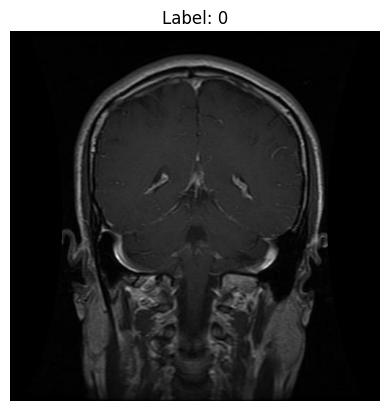

---------------------------------------------------
Number of Classes:  4


In [ ]:
AUTOTUNE = tf.data.AUTOTUNE
batch_size = 32

# Split data into train+val and test (10% test)
train_val_paths, test_paths, train_val_labels, test_labels = train_test_split(
    df['full_path'], df['label_encoded'],
    test_size=0.1, random_state=42, stratify=df['label_encoded']
)

# Split train+val into train and val (10% of train_val as val)
train_paths, val_paths, train_labels, val_labels = train_test_split(
    train_val_paths, train_val_labels,
    test_size=0.1, random_state=42, stratify=train_val_labels
)

# Load + preprocess (no augmentation for val/test)
def load_and_preprocess(path, label):
    return preprocess_image(path, augment=False), label

# Train dataset (with augmentation)
train_ds = tf.data.Dataset.from_tensor_slices((train_paths, train_labels))
train_ds = train_ds.shuffle(buffer_size=len(train_paths))  # shuffle paths+labels
train_ds = train_ds.map(lambda x, y: (preprocess_image(x, augment=False), y),
                        num_parallel_calls=AUTOTUNE)
train_ds = train_ds.batch(batch_size).prefetch(AUTOTUNE)

# Validation dataset (no augmentation)
val_ds = tf.data.Dataset.from_tensor_slices((val_paths, val_labels))
val_ds = val_ds.map(load_and_preprocess, num_parallel_calls=AUTOTUNE)
val_ds = val_ds.batch(batch_size).cache("/tmp/val_cache").prefetch(AUTOTUNE)

# Test dataset (no augmentation)
test_ds = tf.data.Dataset.from_tensor_slices((test_paths, test_labels))
test_ds = test_ds.map(load_and_preprocess, num_parallel_calls=AUTOTUNE)
test_ds = test_ds.batch(batch_size).cache("/tmp/test_cache").prefetch(AUTOTUNE)

# Debugging & sanity checks
print("Dataset sizes:")
print(f"Train: {len(train_paths)} images")
print(f"Validation: {len(val_paths)} images")
print(f"Test: {len(test_paths)} images")
print("--------------------------------------------------")
print("Train labels sample:", train_labels[:10])
print("Validation labels sample:", val_labels[:10])
print("Test labels sample:", test_labels[:10])

# Preview normalized image stats and visualization
for image_batch, label_batch in train_ds.take(1):
    image = image_batch[0]
    label = label_batch[0]
    print("Image dtype:", image.dtype)
    print("Min pixel value:", tf.reduce_min(image).numpy())
    print("Max pixel value:", tf.reduce_max(image).numpy())
    print("Label:", label.numpy())

    plt.imshow(image.numpy())
    plt.title(f"Label: {label.numpy()}")
    plt.axis('off')
    plt.show()

print("---------------------------------------------------")
print("Number of Classes: ", len(le.classes_))

In [ ]:
all_mins, all_maxs = [], []

for image_batch, _ in train_ds:  # goes through the entire dataset
    all_mins.append(np.min(image_batch.numpy()))
    all_maxs.append(np.max(image_batch.numpy()))

print("Global min pixel value:", np.min(all_mins))
print("Global max pixel value:", np.max(all_maxs))

Global min pixel value: 0.0
Global max pixel value: 1.0


In [ ]:
# After train_ds is defined
for image_batch, label_batch in train_ds.take(1):
    print("Image batch shape:", image_batch.shape)  # full batch shape
    print("Label batch shape:", label_batch.shape)  # labels shape

    input_shape = image_batch.shape[1:]  # shape of a single image
    print("Single image shape:", input_shape)
    break

Image batch shape: (32, 512, 512, 3)
Label batch shape: (32,)
Single image shape: (512, 512, 3)


# **Model Loading**

In [ ]:
inception = InceptionV3(input_shape=input_shape, weights='imagenet', include_top=False)

# don't train existing weights
for layer in inception.layers:
    layer.trainable = False

# Number of classes
print("Number of Classes: ", len(le.classes_))

87910968/87910968 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Number of Classes:  4


In [ ]:
x = GlobalAveragePooling2D()(inception.output)
x = Dense(512, activation='relu')(x)
x = Dropout(0.5)(x)
prediction = Dense(len(le.classes_), activation='softmax')(x)

# create a model object
model = Model(inputs=inception.input, outputs=prediction)

# view the structure of the model
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 512, 512,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 255, 255,  │        864 │ input_layer[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 255, 255,  │         96 │ conv2d[0][0]      │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation          │ (None, 255, 255,  │          0 │ batch_normalizat… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 253, 253,  │      9,216 │ activation[0][0]  │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 253, 253,  │         96 │ conv2d_1[0][0]    │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_1        │ (None, 253, 253,  │          0 │ batch_normalizat… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 253, 253,  │     18,432 │ activation_1[0][… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 253, 253,  │        192 │ conv2d_2[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_2        │ (None, 253, 253,  │          0 │ batch_normalizat… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 126, 126,  │          0 │ activation_2[0][… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 126, 126,  │      5,120 │ max_pooling2d[0]… │
│                     │ 80)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 126, 126,  │        240 │ conv2d_3[0][0]    │
│ (BatchNormalizatio… │ 80)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_3        │ (None, 126, 126,  │          0 │ batch_normalizat… │
│ (Activation)        │ 80)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 124, 124,  │    138,240 │ activation_3[0][… │
│                     │ 192)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 124, 124,  │        576 │ conv2d_4[0][0]    │
│ (BatchNormalizatio… │ 192)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_4        │ (None, 124, 124,  │          0 │ batch_normalizat

 Total params: 22,853,924 (87.18 MB)

 Trainable params: 1,051,140 (4.01 MB)

 Non-trainable params: 21,802,784 (83.17 MB)

In [ ]:
# tell the model what cost and optimization method to use
model.compile(
  loss='sparse_categorical_crossentropy', # Two classes
  optimizer='adam',
  metrics=['accuracy']
)

# **Model Training**

In [ ]:
callbacks = [
    EarlyStopping(monitor='val_loss', patience=40, restore_best_weights=True,  verbose = 1),
    ModelCheckpoint("best_model.h5", save_best_only=True, monitor='val_loss',  verbose = 1),
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=10, min_lr=1e-5, verbose = 1)
]

history = model.fit(train_ds, validation_data=val_ds, epochs=50, callbacks=callbacks, verbose = 1)

Epoch 1/50
203/203 ━━━━━━━━━━━━━━━━━━━━ 0s 177ms/step - accuracy: 0.6295 - loss: 0.8691
Epoch 1: val_loss improved from inf to 0.40260, saving model to best_model.h5


203/203 ━━━━━━━━━━━━━━━━━━━━ 92s 316ms/step - accuracy: 0.6299 - loss: 0.8682 - val_accuracy: 0.8403 - val_loss: 0.4026 - learning_rate: 0.0010
Epoch 2/50
203/203 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step - accuracy: 0.8307 - loss: 0.4666
Epoch 2: val_loss did not improve from 0.40260
203/203 ━━━━━━━━━━━━━━━━━━━━ 25s 123ms/step - accuracy: 0.8307 - loss: 0.4666 - val_accuracy: 0.7722 - val_loss: 0.5046 - learning_rate: 0.0010
Epoch 3/50
203/203 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step - accuracy: 0.8378 - loss: 0.4343
Epoch 3: val_loss improved from 0.40260 to 0.31416, saving model to best_model.h5


203/203 ━━━━━━━━━━━━━━━━━━━━ 42s 130ms/step - accuracy: 0.8378 - loss: 0.4342 - val_accuracy: 0.8806 - val_loss: 0.3142 - learning_rate: 0.0010
Epoch 4/50
203/203 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step - accuracy: 0.8517 - loss: 0.3773
Epoch 4: val_loss improved from 0.31416 to 0.29604, saving model to best_model.h5


203/203 ━━━━━━━━━━━━━━━━━━━━ 41s 128ms/step - accuracy: 0.8517 - loss: 0.3772 - val_accuracy: 0.8889 - val_loss: 0.2960 - learning_rate: 0.0010
Epoch 5/50
203/203 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step - accuracy: 0.8703 - loss: 0.3320
Epoch 5: val_loss improved from 0.29604 to 0.27307, saving model to best_model.h5


203/203 ━━━━━━━━━━━━━━━━━━━━ 27s 131ms/step - accuracy: 0.8703 - loss: 0.3321 - val_accuracy: 0.9028 - val_loss: 0.2731 - learning_rate: 0.0010
Epoch 6/50
203/203 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step - accuracy: 0.8873 - loss: 0.3020
Epoch 6: val_loss improved from 0.27307 to 0.26939, saving model to best_model.h5


203/203 ━━━━━━━━━━━━━━━━━━━━ 41s 129ms/step - accuracy: 0.8873 - loss: 0.3021 - val_accuracy: 0.9028 - val_loss: 0.2694 - learning_rate: 0.0010
Epoch 7/50
203/203 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step - accuracy: 0.8809 - loss: 0.3064
Epoch 7: val_loss improved from 0.26939 to 0.24590, saving model to best_model.h5


203/203 ━━━━━━━━━━━━━━━━━━━━ 27s 132ms/step - accuracy: 0.8809 - loss: 0.3063 - val_accuracy: 0.9083 - val_loss: 0.2459 - learning_rate: 0.0010
Epoch 8/50
203/203 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step - accuracy: 0.8879 - loss: 0.2911
Epoch 8: val_loss improved from 0.24590 to 0.22229, saving model to best_model.h5


203/203 ━━━━━━━━━━━━━━━━━━━━ 26s 129ms/step - accuracy: 0.8879 - loss: 0.2911 - val_accuracy: 0.9153 - val_loss: 0.2223 - learning_rate: 0.0010
Epoch 9/50
203/203 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step - accuracy: 0.9004 - loss: 0.2599
Epoch 9: val_loss did not improve from 0.22229
203/203 ━━━━━━━━━━━━━━━━━━━━ 40s 125ms/step - accuracy: 0.9004 - loss: 0.2599 - val_accuracy: 0.9153 - val_loss: 0.2230 - learning_rate: 0.0010
Epoch 10/50
203/203 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step - accuracy: 0.9009 - loss: 0.2548
Epoch 10: val_loss improved from 0.22229 to 0.21566, saving model to best_model.h5


203/203 ━━━━━━━━━━━━━━━━━━━━ 27s 132ms/step - accuracy: 0.9009 - loss: 0.2548 - val_accuracy: 0.9167 - val_loss: 0.2157 - learning_rate: 0.0010
Epoch 11/50
203/203 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step - accuracy: 0.9100 - loss: 0.2324
Epoch 11: val_loss improved from 0.21566 to 0.20995, saving model to best_model.h5


203/203 ━━━━━━━━━━━━━━━━━━━━ 26s 130ms/step - accuracy: 0.9099 - loss: 0.2324 - val_accuracy: 0.9153 - val_loss: 0.2100 - learning_rate: 0.0010
Epoch 12/50
203/203 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step - accuracy: 0.9188 - loss: 0.2171
Epoch 12: val_loss did not improve from 0.20995
203/203 ━━━━━━━━━━━━━━━━━━━━ 40s 125ms/step - accuracy: 0.9187 - loss: 0.2172 - val_accuracy: 0.9222 - val_loss: 0.2172 - learning_rate: 0.0010
Epoch 13/50
203/203 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step - accuracy: 0.9183 - loss: 0.2186
Epoch 13: val_loss improved from 0.20995 to 0.19344, saving model to best_model.h5


203/203 ━━━━━━━━━━━━━━━━━━━━ 27s 132ms/step - accuracy: 0.9183 - loss: 0.2187 - val_accuracy: 0.9208 - val_loss: 0.1934 - learning_rate: 0.0010
Epoch 14/50
203/203 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step - accuracy: 0.9020 - loss: 0.2351
Epoch 14: val_loss did not improve from 0.19344
203/203 ━━━━━━━━━━━━━━━━━━━━ 25s 125ms/step - accuracy: 0.9020 - loss: 0.2351 - val_accuracy: 0.9319 - val_loss: 0.1982 - learning_rate: 0.0010
Epoch 15/50
203/203 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step - accuracy: 0.9200 - loss: 0.2223
Epoch 15: val_loss did not improve from 0.19344
203/203 ━━━━━━━━━━━━━━━━━━━━ 25s 124ms/step - accuracy: 0.9200 - loss: 0.2223 - val_accuracy: 0.9264 - val_loss: 0.1997 - learning_rate: 0.0010
Epoch 16/50
203/203 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step - accuracy: 0.9234 - loss: 0.1951
Epoch 16: val_loss did not improve from 0.19344
203/203 ━━━━━━━━━━━━━━━━━━━━ 42s 127ms/step - accuracy: 0.9234 - loss: 0.1951 - val_accuracy: 0.9208 - val_loss: 0.2241 - learning_rate: 0.0010
Epoch 17/50
2

203/203 ━━━━━━━━━━━━━━━━━━━━ 28s 139ms/step - accuracy: 0.9312 - loss: 0.1781 - val_accuracy: 0.9292 - val_loss: 0.1904 - learning_rate: 0.0010
Epoch 22/50
203/203 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step - accuracy: 0.9339 - loss: 0.1780
Epoch 22: val_loss did not improve from 0.19036
203/203 ━━━━━━━━━━━━━━━━━━━━ 38s 124ms/step - accuracy: 0.9339 - loss: 0.1780 - val_accuracy: 0.9361 - val_loss: 0.1914 - learning_rate: 0.0010
Epoch 23/50
203/203 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step - accuracy: 0.9289 - loss: 0.1726
Epoch 23: val_loss did not improve from 0.19036
203/203 ━━━━━━━━━━━━━━━━━━━━ 26s 128ms/step - accuracy: 0.9289 - loss: 0.1726 - val_accuracy: 0.9250 - val_loss: 0.2232 - learning_rate: 0.0010
Epoch 24/50
203/203 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step - accuracy: 0.9287 - loss: 0.1826
Epoch 24: val_loss improved from 0.19036 to 0.18253, saving model to best_model.h5


203/203 ━━━━━━━━━━━━━━━━━━━━ 41s 129ms/step - accuracy: 0.9288 - loss: 0.1826 - val_accuracy: 0.9333 - val_loss: 0.1825 - learning_rate: 0.0010
Epoch 25/50
203/203 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step - accuracy: 0.9304 - loss: 0.1752
Epoch 25: val_loss did not improve from 0.18253
203/203 ━━━━━━━━━━━━━━━━━━━━ 26s 128ms/step - accuracy: 0.9304 - loss: 0.1751 - val_accuracy: 0.9181 - val_loss: 0.2114 - learning_rate: 0.0010
Epoch 26/50
203/203 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step - accuracy: 0.9404 - loss: 0.1618
Epoch 26: val_loss did not improve from 0.18253
203/203 ━━━━━━━━━━━━━━━━━━━━ 40s 125ms/step - accuracy: 0.9404 - loss: 0.1619 - val_accuracy: 0.9389 - val_loss: 0.1895 - learning_rate: 0.0010
Epoch 27/50
203/203 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step - accuracy: 0.9334 - loss: 0.1621
Epoch 27: val_loss did not improve from 0.18253
203/203 ━━━━━━━━━━━━━━━━━━━━ 26s 129ms/step - accuracy: 0.9334 - loss: 0.1621 - val_accuracy: 0.9347 - val_loss: 0.2063 - learning_rate: 0.0010
Epoch 28/50
2

203/203 ━━━━━━━━━━━━━━━━━━━━ 42s 131ms/step - accuracy: 0.9326 - loss: 0.1748 - val_accuracy: 0.9319 - val_loss: 0.1798 - learning_rate: 0.0010
Epoch 32/50
203/203 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step - accuracy: 0.9486 - loss: 0.1314
Epoch 32: val_loss improved from 0.17981 to 0.17160, saving model to best_model.h5


203/203 ━━━━━━━━━━━━━━━━━━━━ 43s 139ms/step - accuracy: 0.9486 - loss: 0.1315 - val_accuracy: 0.9528 - val_loss: 0.1716 - learning_rate: 0.0010
Epoch 33/50
203/203 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step - accuracy: 0.9478 - loss: 0.1395
Epoch 33: val_loss did not improve from 0.17160
203/203 ━━━━━━━━━━━━━━━━━━━━ 39s 127ms/step - accuracy: 0.9478 - loss: 0.1395 - val_accuracy: 0.9431 - val_loss: 0.1871 - learning_rate: 0.0010
Epoch 34/50
203/203 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step - accuracy: 0.9462 - loss: 0.1420
Epoch 34: val_loss did not improve from 0.17160
203/203 ━━━━━━━━━━━━━━━━━━━━ 41s 127ms/step - accuracy: 0.9462 - loss: 0.1420 - val_accuracy: 0.9306 - val_loss: 0.1914 - learning_rate: 0.0010
Epoch 35/50
203/203 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step - accuracy: 0.9471 - loss: 0.1304
Epoch 35: val_loss did not improve from 0.17160
203/203 ━━━━━━━━━━━━━━━━━━━━ 26s 127ms/step - accuracy: 0.9471 - loss: 0.1304 - val_accuracy: 0.9306 - val_loss: 0.1996 - learning_rate: 0.0010
Epoch 36/50
2

203/203 ━━━━━━━━━━━━━━━━━━━━ 42s 132ms/step - accuracy: 0.9508 - loss: 0.1241 - val_accuracy: 0.9431 - val_loss: 0.1708 - learning_rate: 0.0010
Epoch 39/50
203/203 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step - accuracy: 0.9485 - loss: 0.1234
Epoch 39: val_loss did not improve from 0.17080
203/203 ━━━━━━━━━━━━━━━━━━━━ 40s 126ms/step - accuracy: 0.9485 - loss: 0.1234 - val_accuracy: 0.9444 - val_loss: 0.1868 - learning_rate: 0.0010
Epoch 40/50
203/203 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step - accuracy: 0.9470 - loss: 0.1250
Epoch 40: val_loss did not improve from 0.17080
203/203 ━━━━━━━━━━━━━━━━━━━━ 26s 127ms/step - accuracy: 0.9470 - loss: 0.1250 - val_accuracy: 0.9431 - val_loss: 0.1788 - learning_rate: 0.0010
Epoch 41/50
203/203 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step - accuracy: 0.9531 - loss: 0.1191
Epoch 41: val_loss did not improve from 0.17080
203/203 ━━━━━━━━━━━━━━━━━━━━ 26s 126ms/step - accuracy: 0.9531 - loss: 0.1192 - val_accuracy: 0.9375 - val_loss: 0.1755 - learning_rate: 0.0010
Epoch 42/50
2

# **Model Evaluation**

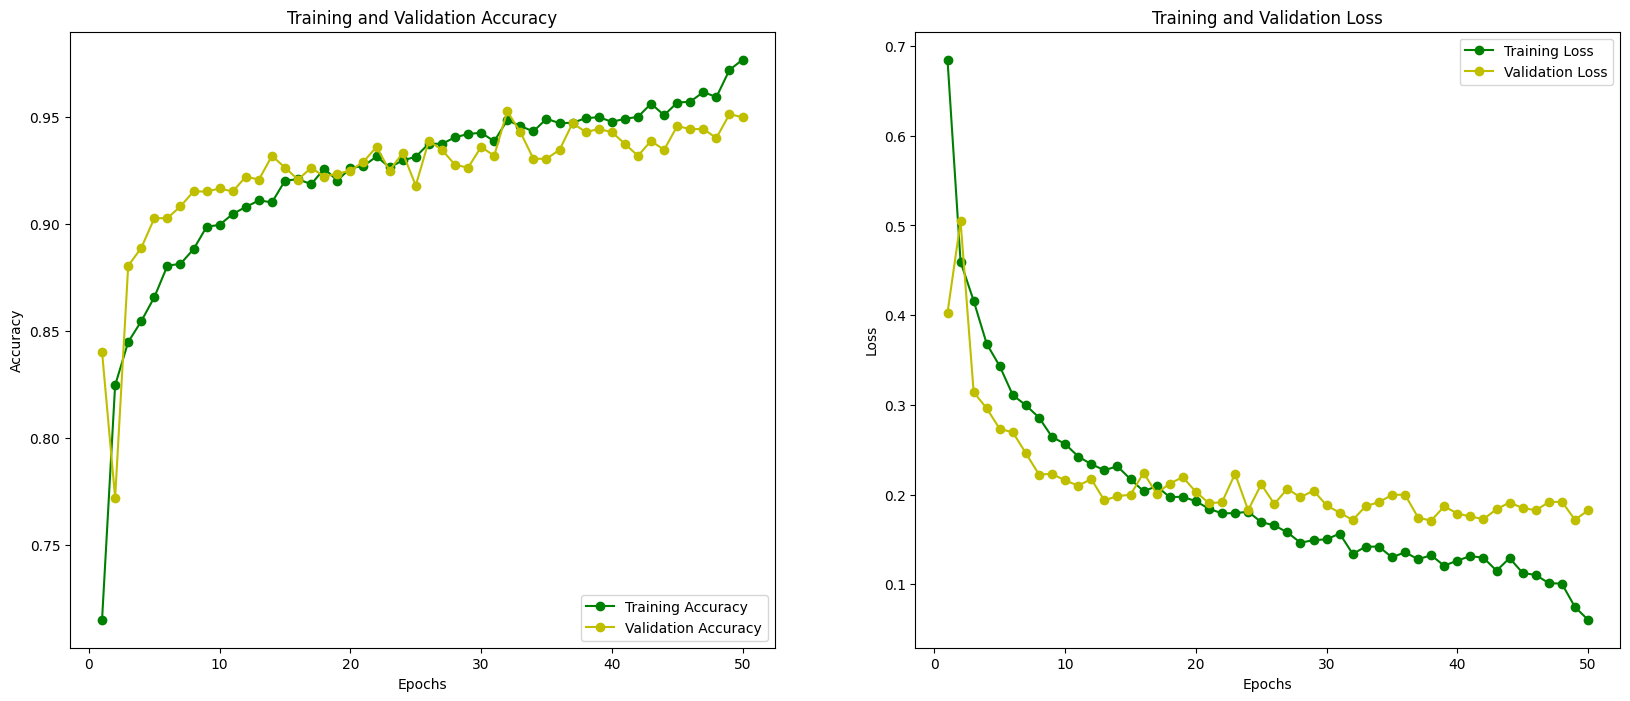

In [ ]:
fig, ax = plt.subplots(1, 2)
fig.set_size_inches(20, 8)

train_acc = history.history['accuracy']
train_loss = history.history['loss']
val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']

epochs = range(1, len(train_acc) + 1)

ax[0].plot(epochs, train_acc, 'g-o', label='Training Accuracy')
ax[0].plot(epochs, val_acc, 'y-o', label='Validation Accuracy')
ax[0].set_title('Training and Validation Accuracy')
ax[0].legend(loc = 'lower right')
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Accuracy')

ax[1].plot(epochs, train_loss, 'g-o', label='Training Loss')
ax[1].plot(epochs, val_loss, 'y-o', label='Validation Loss')
ax[1].set_title('Training and Validation Loss')
ax[1].legend()
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Loss')
plt.show()

25/25 ━━━━━━━━━━━━━━━━━━━━ 18s 421ms/step


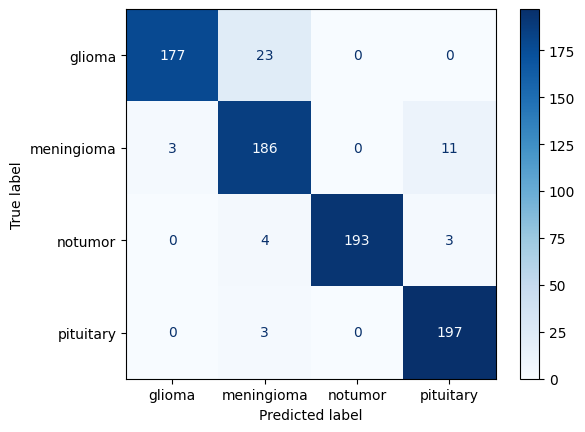

In [ ]:
true_labels = []
for _, labels in test_ds:
    true_labels.extend(labels.numpy())

# Predict with the model
pred_probs = model.predict(test_ds)
pred_labels = np.argmax(pred_probs, axis=1)

# Compute confusion matrix
cm = confusion_matrix(true_labels, pred_labels)

# Display
cm_display = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=le.classes_)
cm_display.plot(cmap='Blues', values_format='d')
plt.show()

In [ ]:
# Evaluate on test dataset
test_loss, test_accuracy = model.evaluate(test_ds, verbose=1)
print(f"Test Accuracy: {test_accuracy:.4f}")

# Predict probabilities
y_pred_probs = model.predict(test_ds)
y_pred = np.argmax(y_pred_probs, axis=1)

# True labels (same order as test_ds batching)
y_true = np.concatenate([y for x, y in test_ds], axis=0)

# Metrics
precision = precision_score(y_true, y_pred, average='macro')
recall = recall_score(y_true, y_pred, average='macro')
f1 = f1_score(y_true, y_pred, average='macro')

print(f"Precision: {precision:.4f}, Recall: {recall:.4f}, F1-score: {f1:.4f}")

# Optional: detailed report per class
print("\nClassification Report:")
print(classification_report(y_true, y_pred, target_names=le.classes_))

25/25 ━━━━━━━━━━━━━━━━━━━━ 3s 133ms/step - accuracy: 0.9365 - loss: 0.1781
Test Accuracy: 0.9413
25/25 ━━━━━━━━━━━━━━━━━━━━ 4s 155ms/step
Precision: 0.9445, Recall: 0.9412, F1-score: 0.9417

Classification Report:
              precision    recall  f1-score   support

      glioma       0.98      0.89      0.93       200
  meningioma       0.86      0.93      0.89       200
     notumor       1.00      0.96      0.98       200
   pituitary       0.93      0.98      0.96       200

    accuracy                           0.94       800
   macro avg       0.94      0.94      0.94       800
weighted avg       0.94      0.94      0.94       800



25/25 ━━━━━━━━━━━━━━━━━━━━ 3s 130ms/step - accuracy: 0.9365 - loss: 0.1781
Test Accuracy: 0.9413
25/25 ━━━━━━━━━━━━━━━━━━━━ 3s 132ms/step

Classification Report:
              precision    recall  f1-score   support

      glioma       0.98      0.89      0.93       200
  meningioma       0.86      0.93      0.89       200
     notumor       1.00      0.96      0.98       200
   pituitary       0.93      0.98      0.96       200

    accuracy                           0.94       800
   macro avg       0.94      0.94      0.94       800
weighted avg       0.94      0.94      0.94       800



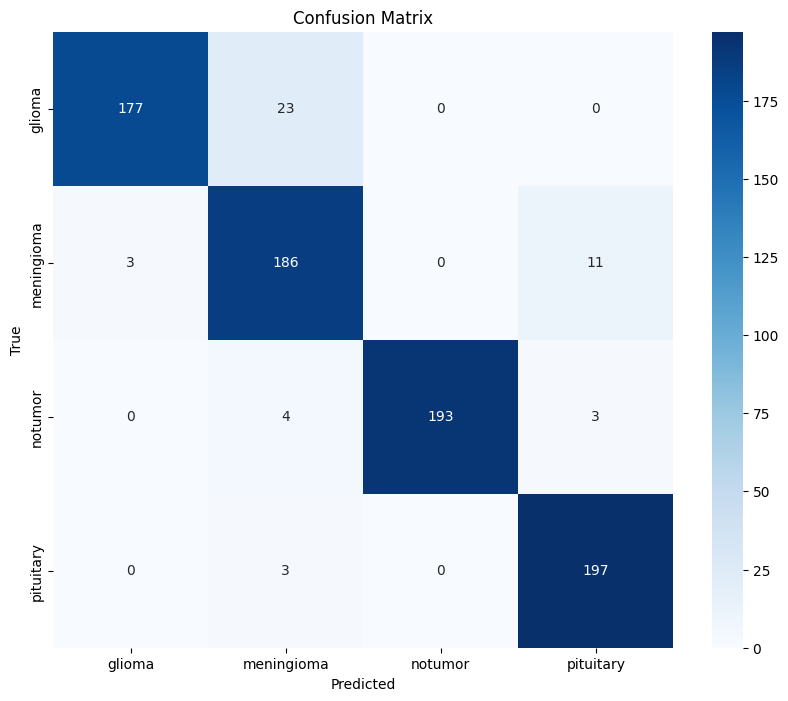

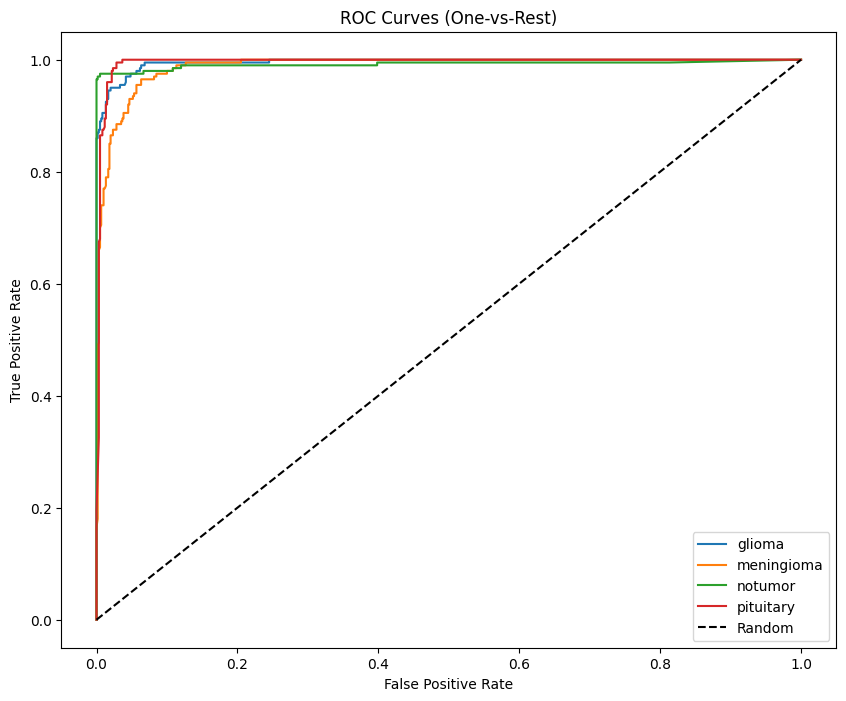

In [ ]:
# Evaluate model
test_loss, test_accuracy = model.evaluate(test_ds, verbose=1)
print(f"Test Accuracy: {test_accuracy:.4f}")

# Predictions
y_probs = model.predict(test_ds)  # shape: (num_samples, num_classes)
y_pred = np.argmax(y_probs, axis=1)

# True labels (extract from test_ds)
y_true = np.concatenate([y for _, y in test_ds], axis=0)

# Classification report
print("\nClassification Report:")
print(classification_report(y_true, y_pred, target_names=le.classes_))

# Confusion matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10,8))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=le.classes_, yticklabels=le.classes_)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()

# ROC curve (multi-class, one-vs-rest)
y_true_bin = label_binarize(y_true, classes=np.arange(len(le.classes_)))  # binarized true labels

plt.figure(figsize=(10,8))
for i in range(len(le.classes_)):
    fpr, tpr, _ = roc_curve(y_true_bin[:, i], y_probs[:, i])
    plt.plot(fpr, tpr, label=f"{le.classes_[i]}")
plt.plot([0,1],[0,1],'k--', label='Random')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curves (One-vs-Rest)")
plt.legend()
plt.show()

In [ ]:
# Predictions
y_probs = model.predict(test_ds)
y_pred = np.argmax(y_probs, axis=1)

# True labels
y_true = np.concatenate([y for _, y in test_ds], axis=0)

# Metrics per class
precision, recall, f1, support = precision_recall_fscore_support(
    y_true, y_pred, average=None, labels=np.arange(len(le.classes_))
)

df_metrics = pd.DataFrame({
    'Class': le.classes_,   # use actual class names instead of 0,1,2,3
    'Precision': precision,
    'Recall': recall,
    'F1-score': f1,
    'Support': support
})

# Sort by F1-score ascending
df_metrics_sorted = df_metrics.sort_values(by='F1-score')
print(df_metrics_sorted)

# Macro averages
precision_macro, recall_macro, f1_macro, _ = precision_recall_fscore_support(
    y_true, y_pred, average='macro'
)
print(f"\nMacro Avg -> Precision: {precision_macro:.4f}, Recall: {recall_macro:.4f}, F1-score: {f1_macro:.4f}")

25/25 ━━━━━━━━━━━━━━━━━━━━ 4s 157ms/step
        Class  Precision  Recall  F1-score  Support
1  meningioma   0.861111   0.930  0.894231      200
0      glioma   0.983333   0.885  0.931579      200
3   pituitary   0.933649   0.985  0.958637      200
2     notumor   1.000000   0.965  0.982188      200

Macro Avg -> Precision: 0.9445, Recall: 0.9412, F1-score: 0.9417


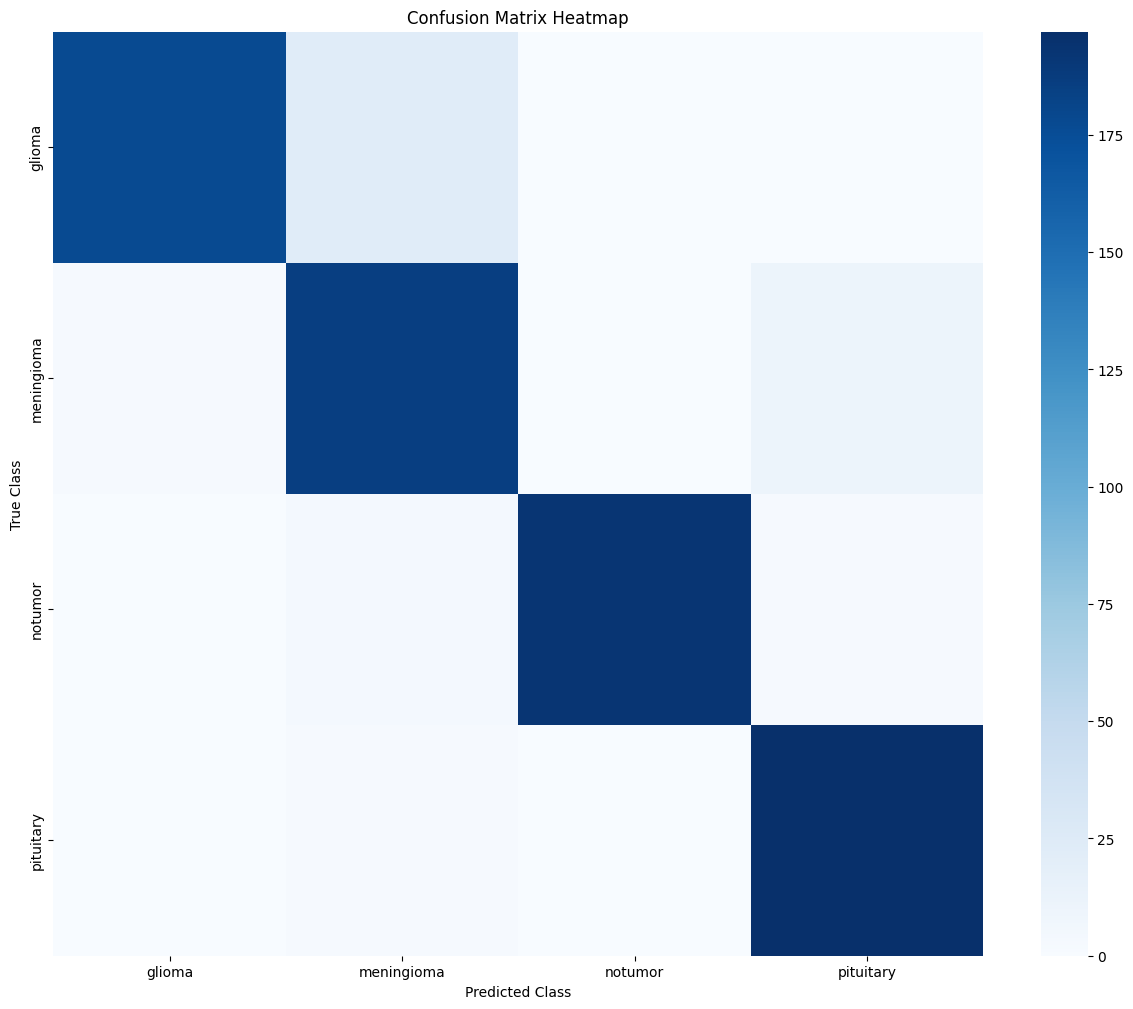

In [ ]:
# Confusion matrix (no annotations, just intensity heatmap)
cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(15,12))
sns.heatmap(cm, annot=False, fmt='d', cmap='Blues',
            xticklabels=le.classes_, yticklabels=le.classes_)
plt.xlabel("Predicted Class")
plt.ylabel("True Class")
plt.title("Confusion Matrix Heatmap")
plt.show()

25/25 ━━━━━━━━━━━━━━━━━━━━ 3s 134ms/step


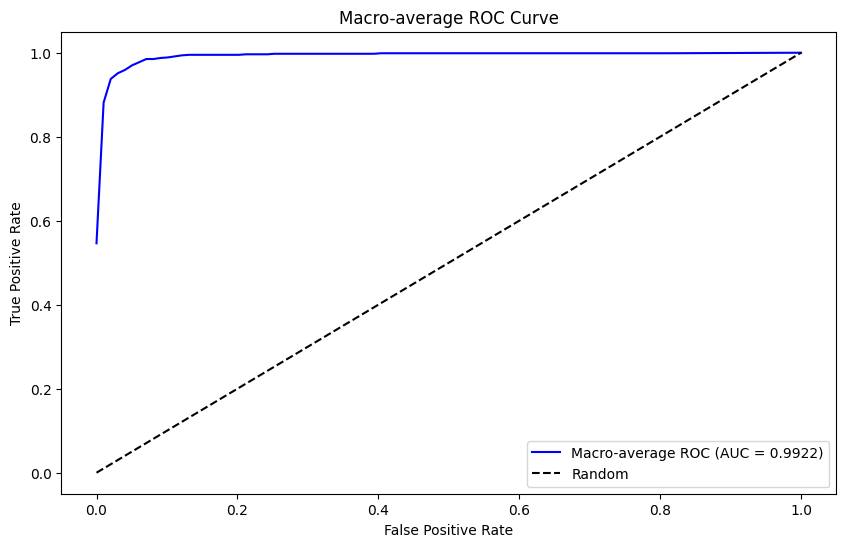

In [ ]:
# Binarize true labels
y_test_bin = label_binarize(y_true, classes=np.arange(len(le.classes_)))

# Predict class probabilities
y_probs = model.predict(test_ds)

# Compute macro-average ROC
all_fpr = np.linspace(0, 1, 100)
mean_tpr = 0

for i in range(len(le.classes_)):
    fpr, tpr, _ = roc_curve(y_test_bin[:, i], y_probs[:, i])
    mean_tpr += np.interp(all_fpr, fpr, tpr)

mean_tpr /= len(le.classes_)
roc_auc = auc(all_fpr, mean_tpr)

# Plot
plt.figure(figsize=(10,6))
plt.plot(all_fpr, mean_tpr, color='b',
         label=f'Macro-average ROC (AUC = {roc_auc:.4f})')
plt.plot([0,1],[0,1],'k--', label='Random')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Macro-average ROC Curve')
plt.legend()
plt.show()

# **Grad-CAM: Model Interpretability**



> [The source code for this implementation was obtained from](https://github.com/gkeechin/vizgradcam/blob/main/gradcam.py)



In [ ]:
last_conv_layer = next(x for x in model.layers [::-1] if isinstance(x, tf.keras.layers.Conv2D))
last_conv_layer.name

'conv2d_93'

In [ ]:
def VizGradCAM(model, image, interpolant=0.5, plot_results=True, true_label=None):
    """
    VizGradCAM - Visualize Grad-CAM for Keras/TensorFlow models with error checking and diagnostics.

    Parameters:
        model: Trained Keras model.
        image: Input image as a NumPy array (H, W, C).
        interpolant: Float between 0 and 1 to mix heatmap and original image.
        plot_results: Whether to display the overlayed image.
        true_label: Optional integer for ground truth class index.

    Returns:
        overlay: Image with Grad-CAM heatmap overlay.
        info: String containing details of the Grad-CAM generation.
    """

    assert 0 < interpolant < 1, "Heatmap interpolation must be between 0 and 1."

    # Find the last Conv2D layer
    try:
        last_conv_layer = next(x for x in model.layers[::-1] if isinstance(x, Conv2D))
    except StopIteration:
        raise ValueError("No Conv2D layer found in the model.")

    target_layer = model.get_layer(last_conv_layer.name)

    # Prepare image
    original_img = image.astype("float32")
    img = np.expand_dims(original_img, axis=0)

    # Get predictions
    preds = model.predict(img, verbose=0)
    predicted_class = int(np.argmax(preds[0]))
    confidence = float(np.max(preds[0]))

    # Use true label if provided
    if true_label is not None:
        pred_idx = int(true_label)
        if pred_idx >= preds.shape[1]:
            raise ValueError(f"True label index {true_label} is out of bounds for model output shape {preds.shape}")
        if predicted_class != true_label:
            import warnings
            warnings.warn(f"Model predicted class {predicted_class} with confidence {confidence:.4f}, but true label is {true_label}.")
    else:
        pred_idx = predicted_class

    # Build a model for Grad-CAM
    with tf.GradientTape() as tape:
        grad_model = Model([model.inputs], [target_layer.output, model.output])
        conv_out, predictions = grad_model(img)
        loss = predictions[:, pred_idx]

    grads = tape.gradient(loss, conv_out)

    # DEBUG Print gradient stats
    if grads is not None:
        grads_np = grads.numpy()
        print("[DEBUG] Grads min/max/mean:",
              np.min(grads_np),
              np.max(grads_np),
              np.mean(grads_np))
    else:
        print("[DEBUG] Grads are None.")

    # Compute pooled gradients and Grad-CAM heatmap
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))
    conv_out = conv_out[0].numpy()
    pooled_grads = pooled_grads.numpy()
    heatmap = np.sum(conv_out * pooled_grads, axis=-1)

    # Normalize heatmap
    heatmap = np.maximum(heatmap, 0)
    heatmap_max = np.max(heatmap)
    zero_heatmap = False  # track if heatmap is all zeros

    if heatmap_max == 0 or np.allclose(heatmap, 0):
        import warnings
        warnings.warn("Heatmap is all zeros. This may indicate that the class is not activated in the image.")
        zero_heatmap = True

    if heatmap_max != 0:
        heatmap /= heatmap_max # Normalize heatmap to [0,1]
    else:
        heatmap = np.zeros_like(heatmap)

    # Resize heatmap to original image size
    h, w = original_img.shape[:2]
    heatmap = cv2.resize(heatmap.astype("float32"), (w, h))

    # Convert heatmap to color
    heatmap = np.uint8(255 * heatmap)
    heatmap_color = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
    heatmap_color = cv2.cvtColor(heatmap_color, cv2.COLOR_BGR2RGB)

    # Normalize original image
    orig_norm = np.uint8(255 * (original_img - np.min(original_img)) / (np.ptp(original_img) + 1e-6))

    # Overlay
    overlay = np.uint8(orig_norm * interpolant + heatmap_color * (1 - interpolant))

    # Annotate overlay if heatmap is all zeros
    if zero_heatmap:
        overlay = cv2.putText(
            overlay.copy(),
            "No Grad-CAM activation",
            (10, h - 10),
            cv2.FONT_HERSHEY_SIMPLEX,
            0.6,
            (255, 255, 255),
            2,
            cv2.LINE_AA
        )

    # Create info string
    info = (
        f"Last conv layer: {last_conv_layer.name} {last_conv_layer.output.shape}\n"
        f"Predicted class: {predicted_class}, Confidence: {confidence:.4f}\n"
        f"Heatmap min/max: {heatmap.min()}/{heatmap.max()}"
    )

    # Optional plot
    if plot_results:
        import matplotlib.pyplot as plt
        plt.imshow(overlay)
        plt.axis("off")
        plt.title(f"Grad-CAM (Class: {pred_idx})")
        plt.show()

    # Logging
    print(f"[INFO] Last conv layer: {last_conv_layer.name} ({last_conv_layer.output.shape})")
    print(f"[INFO] Predicted class: {predicted_class}, Confidence: {confidence:.4f}")
    if true_label is not None:
        print(f"[INFO] True label: {true_label}")
    print(f"[INFO] Heatmap min/max: {heatmap.min()}/{heatmap.max()}")

    return overlay, info

[DEBUG] Grads min/max/mean: -0.0006366 0.000605 8.3e-07
[INFO] Last conv layer: conv2d_93 ((None, 14, 14, 192))
[INFO] Predicted class: 0, Confidence: 0.9932
[INFO] Heatmap min/max: 0/255
[DEBUG] Grads min/max/mean: -0.0001433 9.8e-05 6e-07
[INFO] Last conv layer: conv2d_93 ((None, 14, 14, 192))
[INFO] Predicted class: 3, Confidence: 0.9980
[INFO] Heatmap min/max: 0/254
[DEBUG] Grads min/max/mean: -0.0 -0.0 0.0
[INFO] Last conv layer: conv2d_93 ((None, 14, 14, 192))
[INFO] Predicted class: 2, Confidence: 1.0000
[INFO] Heatmap min/max: 0/0
[DEBUG] Grads min/max/mean: -2.223e-05 4.79e-05 3e-07
[INFO] Last conv layer: conv2d_93 ((None, 14, 14, 192))
[INFO] Predicted class: 1, Confidence: 1.0000
[INFO] Heatmap min/max: 0/254
[DEBUG] Grads min/max/mean: -6.53e-05 3.92e-05 4e-07
[INFO] Last conv layer: conv2d_93 ((None, 14, 14, 192))
[INFO] Predicted class: 3, Confidence: 0.9990
[INFO] Heatmap min/max: 0/254
[DEBUG] Grads min/max/mean: -0.001639 0.002125 7.7e-06
[INFO] Last conv layer: conv2

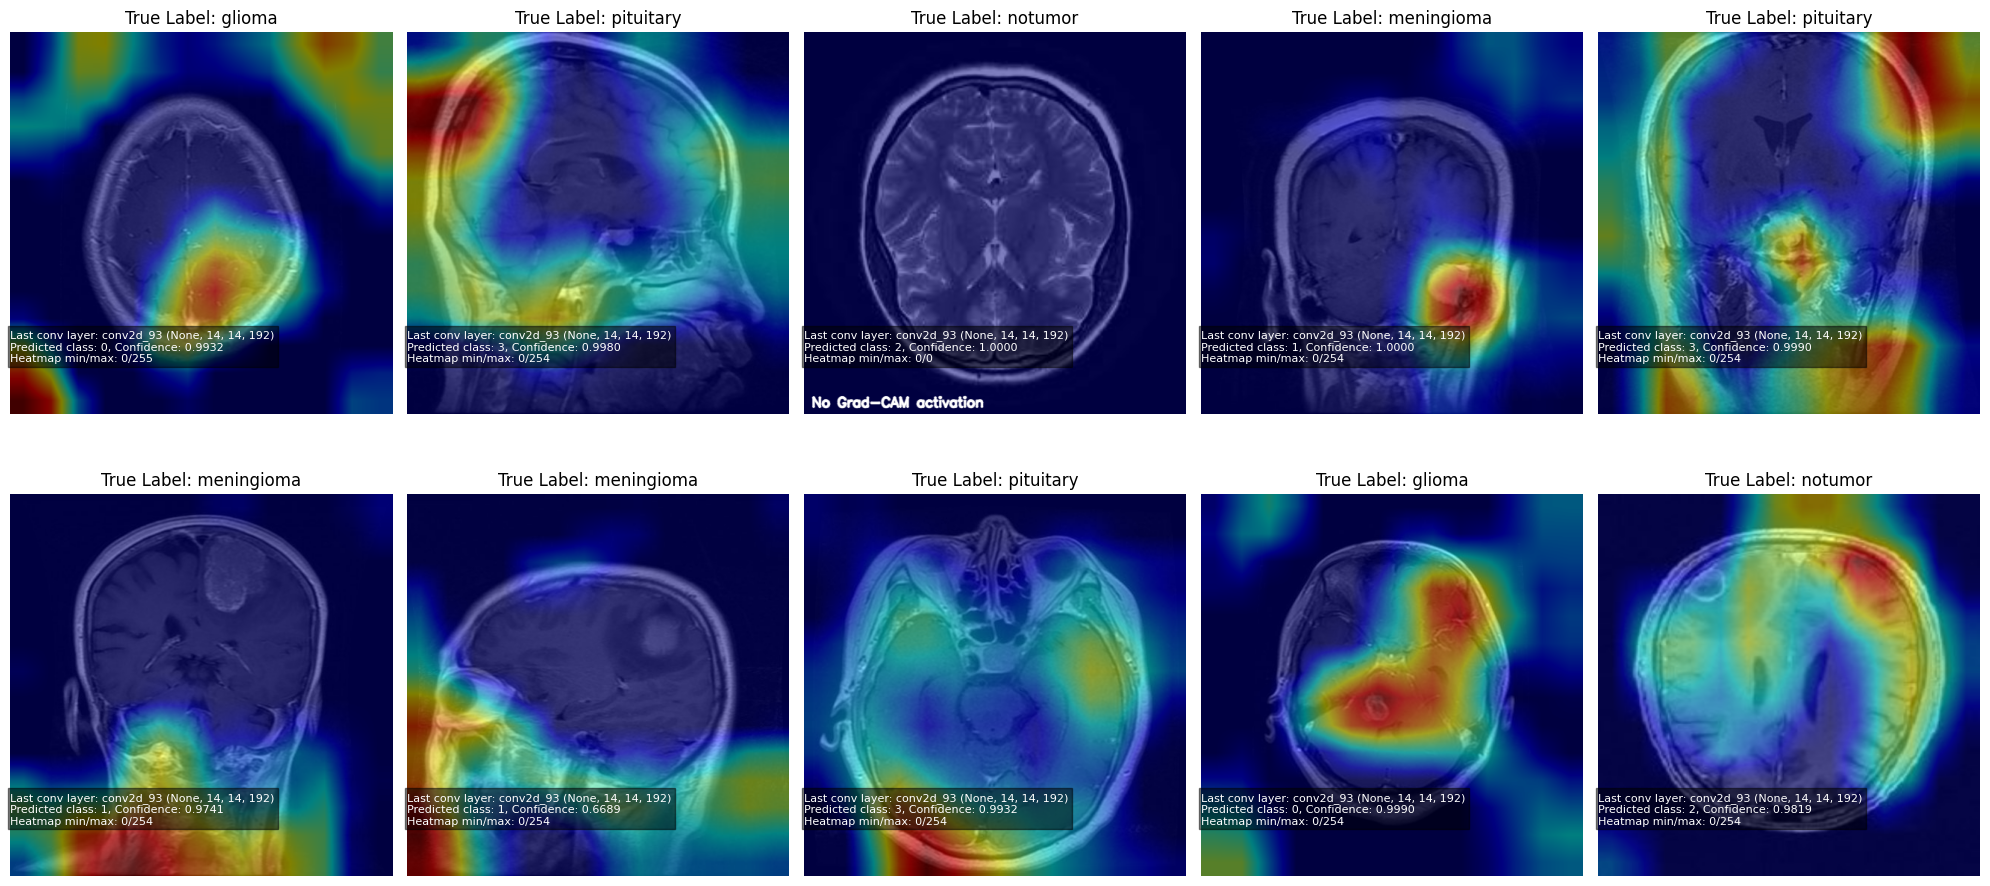

In [ ]:
# Take 10 random samples from test set
n_samples = 10
sample_images = []
sample_labels = []

for img_batch, label_batch in test_ds.unbatch().shuffle(1000).take(n_samples):
    sample_images.append(img_batch.numpy())
    sample_labels.append(label_batch.numpy())

# Plot GradCAM results
plt.figure(figsize=(20, 10))

for i, (img, label) in enumerate(zip(sample_images, sample_labels)):
    plt.subplot(2, 5, i+1)
    overlay_img, info = VizGradCAM(model, img, interpolant=0.5, plot_results=False)
    plt.imshow(overlay_img)
    plt.axis("off")

    # Add title with true label
    plt.title(f"True Label: {le.classes_[label]}")

    # Add info text inside the plot (adjust coordinates & fontsize as needed)
    plt.text(
        0, overlay_img.shape[0] - 70,
        info,
        color='white',
        fontsize=8,
        bbox=dict(facecolor='black', alpha=0.5, pad=2)
    )

plt.tight_layout()
plt.show()

# **Saving the Model**

In [ ]:
model.save("InceptionV3_Brain_Tumor_MRI.h5")
files.download("InceptionV3_Brain_Tumor_MRI.h5")